# Anac flight delay prediction

## Data Loading and Integration

This section loads the Brazilian ANAC VRA (Active Regular Flights) open dataset directly from the official data source.  
Monthly CSV files are dynamically retrieved for the selected year, validated for availability, and merged into a single DataFrame for further analysis.


In [ ]:
import pandas as pd
import requests
from urllib.parse import quote

# Base URL for ANAC open VRA (Active Regular Flights) dataset
BASE_URL = (
    "https://sistemas.anac.gov.br/dadosabertos/"
    "Voos%20e%20opera%C3%A7%C3%B5es%20a%C3%A9reas/"
    "Voo%20Regular%20Ativo%20%28VRA%29/"
)

# Month mapping required to match ANAC folder structure
MONTHS = {
    1: "Janeiro",
    2: "Fevereiro",
    3: "Março",
    4: "Abril",
    5: "Maio",
    6: "Junho",
    7: "Julho",
    8: "Agosto",
    9: "Setembro",
    10: "Outubro",
    11: "Novembro",
    12: "Dezembro",
}

# Years selected for analysis
YEARS = [2023,2024,2025]

dfs = []

def file_exists(url):
    """
    Check if a remote file exists before attempting download.
    This avoids runtime errors caused by missing monthly datasets.
    """
    try:
        r = requests.head(url, timeout=10)
        return r.status_code == 200
    except requests.RequestException:
        return False

# Download and load available monthly datasets
for year in YEARS:
    for month_num, month_name in MONTHS.items():

        folder = f"{month_num:02d} - {month_name}"
        filename = f"VRA_{year}{month_num}.csv"

        url = f"{BASE_URL}{year}/{quote(folder)}/{filename}"

        if not file_exists(url):
            print(f"❌ Missing: {year}-{month_num:02d}")
            continue

        print(f"✔️ Downloading {year}-{month_num:02d}")

        df = pd.read_csv(
            url,
            sep=";",
            encoding="utf-8",
            skiprows=1,
            low_memory=False
        )

        # Add explicit temporal identifiers for downstream analysis
        df["year"] = year
        df["month"] = month_num

        dfs.append(df)

# =========================
# FINAL MERGE
# =========================

# Combine all monthly datasets into a single DataFrame
df_final = pd.concat(dfs, ignore_index=True)

print("✅ All available VRA data merged")
print(df_final.shape)


✔️ Downloading 2023-01


In [ ]:
df_final.to_parquet('vra_anac_2023_2025.parquet')

In [ ]:
import pandas as pd

url = 'https://raw.githubusercontent.com/JessePMelo/anac-flight-delay-prediction/main/data_science/data/processed/vra_anac_2023_2025.parquet'

df_final = pd.read_parquet(url)

df = pd.read_parquet(url)

df_final = df.copy()

After loading, all available monthly datasets are consolidated into a single DataFrame, preserving temporal identifiers (`year` and `month`) to support downstream feature engineering and exploratory analysis.


## Initial Dataset Inspection

After consolidating all available monthly files, an initial inspection is performed to understand the dataset structure, column availability, and basic integrity before proceeding with data preparation.


In [ ]:
df_final

In [ ]:
anac_df = df_final.copy()

In [ ]:
anac_df.info()

In [ ]:
anac_df.isna().sum()

## Missing Values Assessment

Before applying any transformations or filtering, missing values are evaluated to understand data completeness and identify columns that may require cleaning, imputation, or exclusion.


In [ ]:
anac_df.isna().sum()

The inspection shows that missing values are concentrated in a limited set of operational columns.  
These results guide subsequent filtering and cleaning decisions applied in the data preparation stage.


## Removal of Irrelevant and Non-Informative Columns

Some columns in the original dataset do not contribute to the delay prediction objective or are outside the scope of the current analysis. These fields are removed to reduce noise and simplify downstream processing.


In [ ]:
anac_df = anac_df.drop(columns=[
    'Código Autorização (DI)',
    'Código Tipo Linha',
    'Chegada Prevista',
    'Chegada Real',
    'Código Justificativa'
])


## Filtering Completed Flights

Only flights with status `REALIZADO` (completed flights) are retained for analysis.  
Canceled or non-completed flights are excluded, as departure delay cannot be reliably measured for these cases.


In [ ]:
anac_df = anac_df[anac_df['Situação Voo']=='REALIZADO']

In [ ]:
anac_df

This filtering step ensures consistency between the target variable definition and the operational scope of the dataset.


## Removal of Incomplete Records

Records containing missing values are removed to ensure data consistency and avoid introducing bias through artificial imputation.  
Given the operational nature of the dataset, incomplete records cannot be reliably corrected and are excluded from further analysis.


In [ ]:
anac_df = anac_df.dropna()

In [ ]:
anac_df

In [ ]:
anac_df.isna().sum()

This step results in a clean dataset where all remaining records contain the minimum required information for delay calculation and feature engineering.


## Data Type Standardization

Data types are explicitly standardized to ensure semantic correctness, memory efficiency, and compatibility with downstream feature engineering and modeling steps.


In [ ]:
# Create an explicit copy to avoid chained assignment issues
anac_df = anac_df.copy()

# Columns representing identifiers and categorical attributes
category_cols = [
    'ICAO Empresa Aérea',
    'Número Voo',
    'ICAO Aeródromo Origem',
    'ICAO Aeródromo Destino',
    'Situação Voo'
]

# Cast categorical features to pandas 'category' dtype
anac_df[category_cols] = anac_df[category_cols].astype('category')

# Datetime columns used for delay calculation and temporal feature extraction
datetime_cols = [
    'Partida Prevista',
    'Partida Real'
]


Explicit type casting ensures consistent behavior across the data preparation pipeline and prevents ambiguity during feature extraction and modeling.


In [ ]:
anac_df[category_cols] = anac_df[category_cols].astype('category')

In [ ]:
anac_df[datetime_cols] = anac_df[datetime_cols].apply(
    pd.to_datetime,
    dayfirst=True,
    errors='coerce'
)

In [ ]:
anac_df['year'] = anac_df['year'].astype('int16')
anac_df['month'] = anac_df['month'].astype('int8')

In [ ]:
anac_df.info()

## Departure Delay Calculation

The departure delay is computed as the difference between the actual and scheduled departure times.  
This continuous variable represents the foundation for defining the target variable and supports both exploratory analysis and feature engineering.


In [ ]:
anac_df['delay_minutes'] = (
    anac_df['Partida Real'] - anac_df['Partida Prevista']
).dt.total_seconds() / 60


Positive values indicate delayed departures, while negative values represent early departures.  
This feature is used exclusively for target definition and exploratory analysis and is excluded from the modeling feature set to prevent data leakage.


## Target Variable Definition

A binary target variable is defined based on a delay threshold of 15 minutes.  
Flights departing more than 15 minutes after the scheduled time are labeled as delayed.


In [ ]:
anac_df['is_delayed'] = (anac_df['delay_minutes'] > 15).astype('int8')

This binary formulation enables the use of classification models such as logistic regression, while maintaining interpretability and alignment with common operational delay definitions.


## Day of Week Extraction

The day of the week is extracted from the scheduled departure time to capture weekly operational patterns that may influence flight delays.


In [ ]:
anac_df

In [ ]:
anac_df['day_of_week'] = (
    anac_df['Partida Real']
    .dt.dayofweek
    .astype('Int8')
)


The feature ranges from 0 (Monday) to 6 (Sunday) and allows the model to learn differences in delay behavior across weekdays and weekends.


## Temporal Feature Engineering

Multiple calendar-based features are derived from the scheduled departure time to capture seasonal, weekly, and intraday patterns associated with flight delays.


In [ ]:
anac_df['week_of_year'] = (
    anac_df['Partida Real']
    .dt.isocalendar()
    .week
    .astype('Int8')
)


In [ ]:
anac_df['week_of_month'] = (
    ((anac_df['Partida Real'].dt.day - 1) // 7 + 1)
    .astype('Int8')
)


In [ ]:
anac_df['hour'] = (
    anac_df['Partida Real']
    .dt.hour
    .astype('Int8')
)


In [ ]:
anac_df['is_weekend'] = (
    anac_df['day_of_week'] >= 5
).astype('Int8')


In [ ]:
anac_df['day_of_year'] = (
    anac_df['Partida Real']
    .dt.dayofyear
    .astype('Int16')
)


In [ ]:
import pandas as pd
import holidays

# Garantir datetime
anac_df['Partida Prevista'] = pd.to_datetime(
    anac_df['Partida Prevista'],
    errors='coerce'
)

# Datas normalizadas
dates = anac_df['Partida Prevista'].dt.normalize()

# 🔥 Pegar anos reais do dataset
years = dates.dt.year.dropna().unique()

# Criar calendário apenas para esses anos
br_holidays = holidays.Brazil(years=years)

# Converter para DatetimeIndex
holiday_dates = pd.DatetimeIndex(br_holidays.keys()).normalize()

# ------------------------
# Features
# ------------------------

anac_df['is_holiday'] = (
    dates.isin(holiday_dates)
    .astype('Int8')
)

anac_df['is_pre_holiday'] = (
    (dates + pd.Timedelta(days=1))
    .isin(holiday_dates)
    .astype('Int8')
)

anac_df['is_post_holiday'] = (
    (dates - pd.Timedelta(days=1))
    .isin(holiday_dates)
    .astype('Int8')
)


In [ ]:
anac_df

All temporal features are extracted exclusively from scheduled departure times to avoid information leakage and ensure model validity.


## Removal of Leakage-Prone and Non-Modeling Features

Columns that either introduce data leakage or are no longer required after feature extraction are removed to ensure a clean, model-ready dataset.


In [ ]:
cols_to_drop = [
    'Partida Prevista',
    'Partida Real',
    'delay_minutes',
    'Situação Voo',
]

anac_df = anac_df.drop(columns=cols_to_drop)


After this step, the dataset contains only features available at prediction time, fully aligned with the modeling objective.


## Final Dataset Validation

A final inspection is performed to confirm data integrity, data types, and overall readiness for modeling.


In [ ]:
anac_df.head()

In [ ]:
anac_df.info()

## ETL V2

In [ ]:
rename_map = {
    'ICAO Empresa Aérea': 'airline',
    'Número Voo': 'flight_number',
    'ICAO Aeródromo Origem': 'origin_airport',
    'ICAO Aeródromo Destino': 'destination_airport',
}

anac_df = anac_df.rename(columns=rename_map)

In [ ]:
anac_df['airline'] = anac_df['airline'].astype('string')
anac_df['origin_airport'] = anac_df['origin_airport'].astype('string')
anac_df['flight_number'] = anac_df['flight_number'].astype('string')
anac_df['destination_airport'] = anac_df['destination_airport'].astype('string')

In [ ]:
anac_df.info()

In [ ]:
anac_df['route'] = anac_df['origin_airport'].astype('string') + "_" + anac_df['destination_airport'].astype('string')
anac_df['origin_hour'] = anac_df['origin_airport'].astype('string') + "_" + anac_df['hour'].astype('string')

In [ ]:
anac_df['isWeekend_hour'] = anac_df['is_weekend'] * anac_df['hour']

anac_df['holiday_hour'] = anac_df['is_holiday'] * anac_df['hour']

anac_df['preholiday_hour'] = anac_df['is_pre_holiday'] * anac_df['hour']

anac_df['postholiday_hour'] = anac_df['is_post_holiday'] * anac_df['hour']

In [ ]:
anac_df['airline_hour'] = anac_df['airline'].astype('string') + "_" + anac_df['hour'].astype('string')

In [ ]:
anac_df['route_holiday'] = anac_df['route'] + "_" + anac_df['is_holiday'].astype('string')

In [ ]:
import numpy as np

anac_df['hour_sin'] = np.sin(2 * np.pi * anac_df['hour'] / 24)
anac_df['hour_cos'] = np.cos(2 * np.pi * anac_df['hour'] / 24)

In [ ]:
anac_df['is_first_wave'] = (anac_df['hour'] <= 7).astype(int)
anac_df['is_last_wave'] = (anac_df['hour'] >= 20).astype(int)

Sinal congestionamento

In [ ]:
anac_df['origin_volume'] = anac_df.groupby('origin_airport')['origin_airport'].transform('count')

anac_df['destination_volume'] = anac_df.groupby('destination_airport')['destination_airport'].transform('count')

anac_df['route_volume'] = anac_df.groupby('route')['route'].transform('count')

anac_df['airline_delay_rate'] = anac_df.groupby('airline')['is_delayed'].transform('mean')

anac_df['hour_delay_rate'] = anac_df.groupby('hour')['is_delayed'].transform('mean')


## CORR

In [ ]:
corr_matrix = anac_df.corr(numeric_only=True)

corr_with_target = corr_matrix['is_delayed'].sort_values(ascending=False)

corr_with_target


## VIF

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd
import numpy as np

# 1️⃣ Selecionar apenas numéricas (exceto target)
X_vif = (
    anac_df
    .drop(columns=['is_delayed'])
    .select_dtypes(include=['int64', 'Int8', 'Int16', 'float64'])
    .copy()
)

# 2️⃣ Converter tudo para float (obrigatório para VIF)
X_vif = X_vif.astype(float)

# 3️⃣ Remover colunas constantes (evita erro)
X_vif = X_vif.loc[:, X_vif.nunique() > 1]

# 4️⃣ Usar SAMPLE para evitar estouro de RAM
sample_size = 100_000  # pode reduzir para 50_000 se quiser
X_vif_sample = X_vif.sample(
    n=min(sample_size, len(X_vif)),
    random_state=42
)

# 5️⃣ Calcular VIF
vif_data = pd.DataFrame()
vif_data["feature"] = X_vif_sample.columns
vif_data["VIF"] = [
    variance_inflation_factor(X_vif_sample.values, i)
    for i in range(X_vif_sample.shape[1])
]

# 6️⃣ Ordenar
vif_data = vif_data.sort_values(by="VIF", ascending=False)

vif_data


In [ ]:
cols_to_drop = [
    'month',
    'day_of_year',
    'week_of_year',
    'week_of_month',
    'hour',
    'origin_hour',
    'airline_hour',
    'route_holiday',
    'isWeekend_hour',
    'holiday_hour',
    'preholiday_hour',
    'postholiday_hour',
    'route',
    'flight_number'
]

anac_df = anac_df.drop(columns=cols_to_drop)


In [ ]:
anac_df.head(5)

### Separar grupos de colunas

In [ ]:
categorical_cols = [
    'airline',
    'origin_airport',
    'destination_airport',

]

binary_cols = [
    'is_weekend',
    'is_holiday',
    'is_pre_holiday',
    'is_post_holiday',
    'is_first_wave',
    'is_last_wave'
]

continuous_cols = [
    'day_of_week',
    'hour_sin',
    'hour_cos',
    'origin_volume',
    'destination_volume',
    'route_volume',
    'airline_delay_rate',
    'hour_delay_rate'
]



In [ ]:
for col in categorical_cols:
    anac_df[col] = anac_df[col].astype('category')

for col in continuous_cols:
    anac_df[col] = anac_df[col].astype(float)


## Preprocessor

In [ ]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

preprocessor = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), continuous_cols),
        ('bin', 'passthrough', binary_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


## Model

In [ ]:
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

rl_model = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(
        penalty='l2',
        C=0.5,
        solver='saga',          # Melhor para muitos dados + sparse
        max_iter=500,           # 1000 é desnecessário na maioria dos casos
        class_weight='balanced',
        n_jobs=-1,              # Usa todos os núcleos
        random_state=42
    ))
])


In [ ]:
train = anac_df[anac_df['year'].isin([2023, 2024])].copy()
test  = anac_df[anac_df['year'] == 2025].copy()

X_train = train.drop(columns=['is_delayed','year'])
y_train = train['is_delayed']

X_test = test.drop(columns=['is_delayed','year'])
y_test = test['is_delayed']


## Treinar

In [ ]:
rl_model.fit(X_train, y_train)


## Fazer previsões

In [ ]:

from sklearn.metrics import classification_report, roc_auc_score

y_pred_rl = rl_model.predict(X_test)
y_proba_rl = rl_model.predict_proba(X_test)[:, 1]

auc_rl = roc_auc_score(y_test, y_proba_rl)



## Métricas

In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred_rl))
print("AUC:", roc_auc_score(y_test, y_proba_rl))


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_rl)

for i in range(0, len(thresholds), len(thresholds)//10):
    print(f"Threshold: {thresholds[i]:.3f} | Precision: {precision[i]:.3f} | Recall: {recall[i]:.3f}")


In [ ]:
best_threshold = 0.45
y_pred_custom = (y_proba_rl >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_custom))
print("AUC:", roc_auc_score(y_test, y_proba_rl))


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred_rl))
print("AUC:", roc_auc_score(y_test, y_proba_rl))


XGboost

In [ ]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)

pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

pipeline_xgb.fit(X_train, y_train)


In [ ]:
y_pred_xgb = pipeline_xgb.predict(X_test)
y_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]

auc_xgb = roc_auc_score(y_test, y_proba_xgb)


In [ ]:
import numpy as np
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb)

for i in range(0, len(thresholds), len(thresholds)//10):
    print(f"Threshold: {thresholds[i]:.3f} | Precision: {precision[i]:.3f} | Recall: {recall[i]:.3f}")


In [ ]:
best_threshold = 0.470
y_pred_custom = (y_proba_xgb >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_custom))
print("AUC:", roc_auc_score(y_test, y_proba_xgb))


In [ ]:
from sklearn.metrics import classification_report, roc_auc_score

print(classification_report(y_test, y_pred_xgb))
print("AUC:", roc_auc_score(y_test, y_proba_xgb))




## Explicabilida modelo

Comparando classification report RL e XGB

In [ ]:
# Default
report_rl_default = classification_report(y_test, y_pred_rl, output_dict=True)
report_xgb_default = classification_report(y_test, y_pred_xgb, output_dict=True)

# Custom threshold
best_threshold_rl = 0.45
y_pred_rl_custom = (y_proba_rl >= best_threshold_rl).astype(int)
report_rl_custom = classification_report(y_test, y_pred_rl_custom, output_dict=True)

best_threshold_xgb = 0.470
y_pred_xgb_custom = (y_proba_xgb >= best_threshold_xgb).astype(int)
report_xgb_custom = classification_report(y_test, y_pred_xgb_custom, output_dict=True)



In [ ]:
comparison = pd.DataFrame({
    "Model": [
        "Logistic (0.5)",
        "Logistic (Custom)",
        "XGBoost (0.5)",
        "XGBoost (Custom)"
    ],

    "Precision (Class 1)": [
        report_rl_default["1"]["precision"],
        report_rl_custom["1"]["precision"],
        report_xgb_default["1"]["precision"],
        report_xgb_custom["1"]["precision"]
    ],

    "Recall (Class 1)": [
        report_rl_default["1"]["recall"],
        report_rl_custom["1"]["recall"],
        report_xgb_default["1"]["recall"],
        report_xgb_custom["1"]["recall"]
    ],

    "F1-score (Class 1)": [
        report_rl_default["1"]["f1-score"],
        report_rl_custom["1"]["f1-score"],
        report_xgb_default["1"]["f1-score"],
        report_xgb_custom["1"]["f1-score"]
    ],

    "Accuracy": [
        report_rl_default["accuracy"],
        report_rl_custom["accuracy"],
        report_xgb_default["accuracy"],
        report_xgb_custom["accuracy"]
    ],

    "AUC": [
        auc_rl,
        auc_rl,
        auc_xgb,
        auc_xgb
    ]
})

comparison.round(3)


Coef_ RL

In [ ]:
import numpy as np
import pandas as pd

# Pegar nomes das features após OneHot
ohe = rl_model.named_steps['preprocessor'].named_transformers_['cat']
ohe_features = ohe.get_feature_names_out(categorical_cols)

all_features = (
    continuous_cols +
    binary_cols +
    list(ohe_features)
)

# Pegar coeficientes
coef = rl_model.named_steps['classifier'].coef_[0]

coef_df = pd.DataFrame({
    "feature": all_features,
    "coefficient": coef
}).sort_values(by="coefficient", key=abs, ascending=False)

coef_df.to_csv('coef_rl.csv', index=False)
coef_df

Shap RL Global

In [ ]:
import shap
import numpy as np
import pandas as pd

# Transformar X_test pelo preprocessor
X_test_transformed = rl_model.named_steps['preprocessor'].transform(X_test)

# Amostragem
sample_size = 5000
idx = np.random.choice(X_test_transformed.shape[0], sample_size, replace=False)
X_sample = X_test_transformed[idx]

# SHAP Explainer
explainer_rl = shap.LinearExplainer(
    rl_model.named_steps['classifier'],
    X_sample
)

shap_values_rl = explainer_rl.shap_values(X_sample)

# 🔥 Converter para DataFrame para ter cores
if hasattr(X_sample, "toarray"):
    X_sample_dense = X_sample.toarray()
else:
    X_sample_dense = X_sample

X_sample_df = pd.DataFrame(
    X_sample_dense,
    columns=all_features
)

# Plot colorido
shap.summary_plot(
    shap_values_rl,
    X_sample_df
)

feature importance Xgb

In [ ]:
xgb = pipeline_xgb.named_steps['model']

importance_df = pd.DataFrame({
    "feature": all_features,
    "importance": xgb.feature_importances_
}).sort_values(by="importance", ascending=False)

importance_df.to_csv('importance_xgb.csv', index=False)
importance_df

In [ ]:
importance_nonzero = importance_df[
    importance_df['importance'] > 0
].sort_values(by='importance', ascending=False)

importance_nonzero.sort_values(by='importance', ascending=False)
importance_nonzero.to_csv('importance_nonzero_xgb.csv', index=False)
importance_nonzero


Shap xgb

In [ ]:
import shap
import numpy as np
import pandas as pd

# 🔹 Amostragem
sample_size = 5000
idx = np.random.choice(X_test.shape[0], sample_size, replace=False)

X_sample_raw = X_test.iloc[idx]

# 🔹 Transformar pelo preprocessor
X_sample_transformed = pipeline_xgb.named_steps['preprocessor'].transform(X_sample_raw)

# 🔹 Converter para dense se for sparse
if hasattr(X_sample_transformed, "toarray"):
    X_sample_dense = X_sample_transformed.toarray()
else:
    X_sample_dense = X_sample_transformed

# 🔹 Criar DataFrame com nomes corretos
X_sample_df = pd.DataFrame(
    X_sample_dense,
    columns=all_features
)

# 🔹 Criar explainer
explainer_xgb = shap.TreeExplainer(pipeline_xgb.named_steps['model'])

# 🔹 Calcular shap values
shap_values_xgb = explainer_xgb.shap_values(X_sample_df)

# 🔹 Summary plot colorido
shap.summary_plot(shap_values_xgb, X_sample_df)

shap individual

In [ ]:
# 🔹 Adicionar probabilidade ao test_df
test_df_probs = X_test.copy()
test_df_probs["is_delayed"] = y_test
test_df_probs["prob_delay"] = pipeline_xgb.predict_proba(X_test)[:,1]

# 🔹 Caso atraso com maior probabilidade
case_delay = test_df_probs[
    test_df_probs["is_delayed"] == 1
].sort_values("prob_delay", ascending=False).iloc[0]

# 🔹 Caso não atraso com menor probabilidade
case_no_delay = test_df_probs[
    test_df_probs["is_delayed"] == 0
].sort_values("prob_delay", ascending=True).iloc[0]

# 🔹 Separar X
case_delay_X = case_delay.drop(["is_delayed", "prob_delay"]).to_frame().T
case_no_delay_X = case_no_delay.drop(["is_delayed", "prob_delay"]).to_frame().T

# 🔹 Ajustar dtype
case_delay_X = case_delay_X[X_test.columns].astype(X_test.dtypes.to_dict())
case_no_delay_X = case_no_delay_X[X_test.columns].astype(X_test.dtypes.to_dict())

print("Prob delay escolhida:", case_delay["prob_delay"])
print("Prob no delay escolhida:", case_no_delay["prob_delay"])

In [ ]:
case_delay_X

In [ ]:
case_no_delay_X

SHAP individual Regressão logistica

Case delay

In [ ]:
import shap
import numpy as np
import pandas as pd

# 🔹 Extrair nomes reais das features do preprocessor
feature_names = rl_model.named_steps['preprocessor'].get_feature_names_out()

# 🔹 Background
background_idx = np.random.choice(X_train.shape[0], 1000, replace=False)
X_background_raw = X_train.iloc[background_idx]
X_background_transformed = rl_model.named_steps['preprocessor'].transform(X_background_raw)

if hasattr(X_background_transformed, "toarray"):
    X_background = X_background_transformed.toarray()
else:
    X_background = X_background_transformed

# 🔹 Caso individual
X_case_transformed = rl_model.named_steps['preprocessor'].transform(case_delay_X)

if hasattr(X_case_transformed, "toarray"):
    X_case = X_case_transformed.toarray()
else:
    X_case = X_case_transformed

# 🔹 Criar DataFrame COM NOMES
X_case_df = pd.DataFrame(
    X_case,
    columns=feature_names
)

# 🔹 Criar explainer
explainer_rl = shap.LinearExplainer(
    rl_model.named_steps['classifier'],
    X_background
)

# 🔹 SHAP values
shap_values_rl = explainer_rl(X_case_df)



# 🔹 Waterfall com nomes corretos
shap.plots.waterfall(
    shap_values_rl[0],
    max_display=10
)

Case no delay

In [ ]:
import shap
import numpy as np
import pandas as pd

# 🔹 Extrair nomes reais das features do preprocessor
feature_names = rl_model.named_steps['preprocessor'].get_feature_names_out()

# 🔹 Background
background_idx = np.random.choice(X_train.shape[0], 1000, replace=False)
X_background_raw = X_train.iloc[background_idx]
X_background_transformed = rl_model.named_steps['preprocessor'].transform(X_background_raw)

if hasattr(X_background_transformed, "toarray"):
    X_background = X_background_transformed.toarray()
else:
    X_background = X_background_transformed

# 🔹 Caso individual
X_case_transformed = rl_model.named_steps['preprocessor'].transform(case_no_delay_X)

if hasattr(X_case_transformed, "toarray"):
    X_case = X_case_transformed.toarray()
else:
    X_case = X_case_transformed

# 🔹 Criar DataFrame COM NOMES
X_case_df = pd.DataFrame(
    X_case,
    columns=feature_names
)

# 🔹 Criar explainer
explainer_rl = shap.LinearExplainer(
    rl_model.named_steps['classifier'],
    X_background
)

# 🔹 SHAP values
shap_values_rl = explainer_rl(X_case_df)

# 🔹 Waterfall com nomes corretos
shap.plots.waterfall(
    shap_values_rl[0],
    max_display=10
)

SHAP individual Xgboost

Case delay

In [ ]:
import shap
import numpy as np
import pandas as pd

# 🔹 Extrair nomes reais das features
feature_names = pipeline_xgb.named_steps['preprocessor'].get_feature_names_out()

# 🔹 Transformar caso individual
X_case_transformed = pipeline_xgb.named_steps['preprocessor'].transform(case_delay_X)

# 🔹 Converter para dense se necessário
if hasattr(X_case_transformed, "toarray"):
    X_case = X_case_transformed.toarray()
else:
    X_case = X_case_transformed

# 🔹 Criar DataFrame com nomes corretos
X_case_df = pd.DataFrame(
    X_case,
    columns=feature_names
)

# 🔹 Criar explainer (TreeExplainer)
explainer_xgb = shap.TreeExplainer(
    pipeline_xgb.named_steps['model']
)

# 🔹 Calcular shap values
shap_values_xgb = explainer_xgb(X_case_df)

# 🔹 Waterfall plot
shap.plots.waterfall(
    shap_values_xgb[0],
    max_display=40
)

Case no delay

In [ ]:
import shap
import numpy as np
import pandas as pd

# 🔹 Extrair nomes reais das features
feature_names = pipeline_xgb.named_steps['preprocessor'].get_feature_names_out()

# 🔹 Transformar caso individual
X_case_transformed = pipeline_xgb.named_steps['preprocessor'].transform(case_no_delay_X)

# 🔹 Converter para dense se necessário
if hasattr(X_case_transformed, "toarray"):
    X_case = X_case_transformed.toarray()
else:
    X_case = X_case_transformed

# 🔹 Criar DataFrame com nomes corretos
X_case_df = pd.DataFrame(
    X_case,
    columns=feature_names
)

# 🔹 Criar explainer (TreeExplainer)
explainer_xgb = shap.TreeExplainer(
    pipeline_xgb.named_steps['model']
)

# 🔹 Calcular shap values
shap_values_xgb = explainer_xgb(X_case_df)

# 🔹 Waterfall plot
shap.plots.waterfall(
    shap_values_xgb[0],
    max_display=40
)

In [ ]:
import numpy as np
from scipy.special import expit

model = pipeline_xgb.named_steps['model']

# Transformar o mesmo caso
X_transformed = pipeline_xgb.named_steps['preprocessor'].transform(case_no_delay_X)

if hasattr(X_transformed, "toarray"):
    X_transformed = X_transformed.toarray()

# 1️⃣ Margem direta do modelo
margin_direct = model.predict(X_transformed, output_margin=True)[0]

# 2️⃣ Probabilidade via margem
prob_from_margin = expit(margin_direct)

# 3️⃣ Probabilidade via predict_proba do MODELO isolado
prob_model_only = model.predict_proba(X_transformed)[0,1]

# 4️⃣ Probabilidade via PIPELINE
prob_pipeline = pipeline_xgb.predict_proba(case_no_delay_X)[0,1]

print("Margin direta:", margin_direct)
print("Prob via expit(margin):", prob_from_margin)
print("Prob via model.predict_proba:", prob_model_only)

## Joblib

In [ ]:
import joblib

joblib.dump(pipeline_xgb, "xgb_pipeline.pkl")

## Wrapper

In [ ]:
%%writefile model_wrapper.py

import joblib
import shap
import numpy as np
import pandas as pd


class FlightDelayPredictor:

    def __init__(self, model_path: str, threshold: float = 0.5):
        """
        model_path: caminho do pipeline salvo (.pkl)
        threshold: limite mínimo para classificar como delay
        """
        self.pipeline = joblib.load(model_path)
        self.threshold = threshold

        self.preprocessor = self.pipeline.named_steps["preprocessor"]
        self.model = self.pipeline.named_steps["model"]

        # SHAP explainer
        self.explainer = shap.TreeExplainer(self.model)

        self.feature_names = self.preprocessor.get_feature_names_out()

    # ====================================================
    # 🔹 Converter hora → sin/cos (ANTES do pipeline)
    # ====================================================
    def _encode_hour(self, hour: int):
        hour_sin = np.sin(2 * np.pi * hour / 24)
        hour_cos = np.cos(2 * np.pi * hour / 24)
        return hour_sin, hour_cos

    # ====================================================
    # 🔹 Preparar input para pipeline
    # ====================================================
    def _prepare_input(self, input_data: dict):

        if "hour" not in input_data:
            raise ValueError("Input must contain 'hour' field.")

        input_copy = input_data.copy()

        hour = input_copy.pop("hour")

        hour_sin, hour_cos = self._encode_hour(hour)

        input_copy["hour_sin"] = hour_sin
        input_copy["hour_cos"] = hour_cos

        X = pd.DataFrame([input_copy])

        return X

    # ====================================================
    # 🔹 Predict com threshold customizado
    # ====================================================
    def predict(self, input_data: dict):

        X = self._prepare_input(input_data)

        probs = self.pipeline.predict_proba(X)[0]

        prob_no_delay = float(probs[0])
        prob_delay = float(probs[1])

        predicted_class = int(prob_delay >= self.threshold)
        label = "Delayed" if predicted_class == 1 else "On Time"

        return {
            "prediction": predicted_class,
            "label": label,
            "probability_delay": prob_delay,
            "probability_no_delay": prob_no_delay,
            "threshold_used": self.threshold
        }

    # ====================================================
    # 🔹 SHAP Explain
    # ====================================================
    def explain(self, input_data: dict, top_n: int = 10):

        X = self._prepare_input(input_data)

        # transformar manualmente (igual pipeline faz internamente)
        X_transformed = self.preprocessor.transform(X)

        if hasattr(X_transformed, "toarray"):
            X_transformed = X_transformed.toarray()

        shap_values = self.explainer(X_transformed)
        values = shap_values.values[0]

        idx_sorted = np.argsort(np.abs(values))[::-1]

        top_features = []

        for i in idx_sorted:
            feature_name = self.feature_names[i]

            # remover sin/cos da explicação para humano
            if "hour_sin" in feature_name or "hour_cos" in feature_name:
                continue

            top_features.append({
                "feature": feature_name,
                "impact": float(values[i])
            })

            if len(top_features) >= top_n:
                break

        return top_features

    # ====================================================
    # 🔹 Resposta completa
    # ====================================================
    def predict_with_explanation(self, input_data: dict, top_n: int = 10):

        prediction_output = self.predict(input_data)
        shap_output = self.explain(input_data, top_n=top_n)

        return {
            **prediction_output,
            "departure_hour": input_data["hour"],
            "top_factors": shap_output
        }

Teste

In [ ]:
from model_wrapper import FlightDelayPredictor

# ======================================================
# 🔹 Instanciar wrapper (carrega automaticamente o .pkl)
# ======================================================
predictor = FlightDelayPredictor(
    model_path="xgb_pipeline.pkl",  # ajuste se estiver em pasta models/
    threshold=0.5
)

# ======================================================
# 🔴 CASO DELAY (mesmo exemplo do notebook)
# ======================================================
case_delay = {
    "airline": "AEA",
    "origin_airport": "LEMD",
    "destination_airport": "SBGR",
    "hour": 22,  # usuário envia hora normal (0–23)
    "day_of_week": 4.0,
    "is_weekend": 0,
    "is_holiday": 0,
    "is_pre_holiday": 0,
    "is_post_holiday": 0,
    "is_first_wave": 0,
    "is_last_wave": 1,
    "origin_volume": 5884.0,
    "destination_volume": 399102.0,
    "route_volume": 4314.0,
    "airline_delay_rate": 0.5974842767295597,
    "hour_delay_rate": 0.221591059442009
}

print("\n==============================")
print("🚨 TESTE REAL - DELAY")
print("==============================")

result_delay = predictor.predict_with_explanation(case_delay, top_n=5)
print(result_delay)


# ======================================================
# 🟢 CASO NO DELAY (exemplo do notebook)
# ======================================================
case_no_delay = {
    "airline": "TAM",
    "origin_airport": "SBRJ",
    "destination_airport": "SBSP",
    "hour": 9,
    "day_of_week": 5.0,
    "is_weekend": 1,
    "is_holiday": 1,
    "is_pre_holiday": 0,
    "is_post_holiday": 0,
    "is_first_wave": 1,
    "is_last_wave": 0,
    "origin_volume": 108990.0,
    "destination_volume": 276071.0,
    "route_volume": 54021.0,
    "airline_delay_rate": 0.1687829774799002,
    "hour_delay_rate": 0.05311182742375403
}

print("\n==============================")
print("✅ TESTE REAL - NO DELAY")
print("==============================")

result_no_delay = predictor.predict_with_explanation(case_no_delay, top_n=5)
print(result_no_delay)

##  V5 — Training Without Leakage


V5 – Data Loading (Processed Dataset)

In this step, the processed ANAC flight delay dataset is loaded directly from the GitHub repository in Parquet format, ensuring efficient storage and faster read performance.

A copy of the original dataframe is created (df_final = df.copy()) to preserve the raw processed dataset.
This allows safe feature engineering and transformations without modifying the base dataset.

Source file:
vra_anac_2023_2025.parquet
(GitHub – processed data folder)

In [1]:

import pandas as pd

url = 'https://raw.githubusercontent.com/JessePMelo/anac-flight-delay-prediction/main/data_science/data/processed/vra_anac_2023_2025.parquet'
df = pd.read_parquet(url)
df_final = df.copy()


V5 – Data Cleaning & Target Engineering

This stage performs the initial dataset cleaning and prepares the target variable for the delay classification task.

1️⃣ Column Removal

Irrelevant or non-predictive columns were removed, including authorization codes, justification codes, and arrival timestamps that are not required for departure delay prediction.

2️⃣ Flight Status Filtering

Only flights with status "REALIZADO" (Completed) were retained to ensure model consistency and avoid noise from cancelled or non-operated flights.

3️⃣ Missing Values Handling

Rows containing missing values were removed to maintain data integrity.

4️⃣ Data Type Optimization

Categorical columns were cast to category dtype to improve memory efficiency and model compatibility.
Datetime columns were converted using pd.to_datetime() with proper error handling.

5️⃣ Delay Calculation

A new feature delay_minutes was created by computing the difference between actual and scheduled departure times.

6️⃣ Target Variable Definition

The binary target variable is_delayed was defined as:

1 → Delay greater than 15 minutes

0 → On-time or delay ≤ 15 minutes

This threshold follows common aviation delay standards.

In [2]:
import pandas as pd
import numpy as np
import holidays

# ==========================
# Limpeza inicial
# ==========================

df = df.drop(columns=[
    'Código Autorização (DI)',
    'Código Tipo Linha',
    'Chegada Prevista',
    'Chegada Real',
    'Código Justificativa'
])

df = df[df['Situação Voo'] == 'REALIZADO'].copy()
df = df.dropna().copy()

# Cast categorias
category_cols = [
    'ICAO Empresa Aérea',
    'Número Voo',
    'ICAO Aeródromo Origem',
    'ICAO Aeródromo Destino',
    'Situação Voo'
]

df[category_cols] = df[category_cols].astype('category')

# Datas
datetime_cols = [
    'Partida Prevista',
    'Partida Real'
]

df[datetime_cols] = df[datetime_cols].apply(
    pd.to_datetime,
    dayfirst=True,
    errors='coerce'
)

# Delay
df['delay_minutes'] = (
    df['Partida Real'] - df['Partida Prevista']
).dt.total_seconds() / 60

df['is_delayed'] = (df['delay_minutes'] > 15).astype('int8')

/tmp/ipython-input-218013862.py:37: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df[datetime_cols] = df[datetime_cols].apply(
/tmp/ipython-input-218013862.py:37: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  df[datetime_cols] = df[datetime_cols].apply(


V5 – Temporal Train/Test Split

To avoid data leakage and simulate a real-world production scenario, a temporal split strategy was applied.

Instead of using a random split, the dataset was divided chronologically:

Training set: Flights from years prior to 2025

Test set: Flights from 2025

This approach ensures that the model is trained only on past data and evaluated on future data, better reflecting real operational conditions.

Temporal validation is especially important in time-dependent problems such as flight delay prediction.

In [3]:
# Split temporal

train = df[df["year"] < 2025].copy()
test  = df[df["year"] == 2025].copy()

V5 – Feature Engineering (Time, Holidays & Operational Patterns)

This step creates structured and domain-driven features to improve model predictive power.

1️⃣ Column Standardization

Column names were renamed to a cleaner and more model-friendly format (airline, origin_airport, destination_airport, etc.) to simplify downstream processing.

2️⃣ Time-Based Features

Operational behavior strongly depends on time. The following variables were created:

day_of_week

hour

is_weekend

These features help capture weekly and hourly delay patterns.

3️⃣ Brazilian National Holidays

Using the holidays library, Brazilian national holidays were mapped dynamically based on the dataset years.

Additional features were engineered:

is_holiday

is_pre_holiday

is_post_holiday

This allows the model to capture abnormal operational patterns during holiday periods.

4️⃣ Cyclical Time Encoding

Since hour is cyclical (23 → 0), sine and cosine transformations were applied:

hour_sin

hour_cos

This prevents artificial distance between late-night and early-morning flights.

5️⃣ Operational Waves

Two operational intensity indicators were created:

is_first_wave (early morning operations)

is_last_wave (late evening operations)

These periods often concentrate cascading delays.

6️⃣ Route-Level Features

To capture route-specific behavior:

route → origin + destination

origin_hour → origin + hour interaction

These interaction features help the model learn congestion patterns by airport and time.

In [4]:
import numpy as np
import pandas as pd
import holidays

def create_base_features(data: pd.DataFrame) -> pd.DataFrame:
    # Renomear colunas para padronizar
    rename_map = {
        'ICAO Empresa Aérea': 'airline',
        'Número Voo': 'flight_number',
        'ICAO Aeródromo Origem': 'origin_airport',
        'ICAO Aeródromo Destino': 'destination_airport',
    }
    data = data.rename(columns=rename_map)

    # Features de tempo
    data['day_of_week'] = data['Partida Real'].dt.dayofweek.astype('Int8')
    data['hour'] = data['Partida Real'].dt.hour.astype('Int8')
    data['is_weekend'] = (data['day_of_week'] >= 5).astype('Int8')

    # Feriados
    dates = data['Partida Prevista'].dt.normalize()
    years = dates.dt.year.dropna().unique()
    br_holidays = holidays.Brazil(years=years)
    holiday_dates = pd.DatetimeIndex(br_holidays.keys()).normalize()

    data['is_holiday'] = dates.isin(holiday_dates).astype('Int8')
    data['is_pre_holiday'] = ((dates + pd.Timedelta(days=1)).isin(holiday_dates)).astype('Int8')
    data['is_post_holiday'] = ((dates - pd.Timedelta(days=1)).isin(holiday_dates)).astype('Int8')

    # Hora cíclica
    data['hour_sin'] = np.sin(2 * np.pi * data['hour'] / 24)
    data['hour_cos'] = np.cos(2 * np.pi * data['hour'] / 24)

    # Janelas de operação
    data['is_first_wave'] = (data['hour'] <= 7).astype(int)
    data['is_last_wave'] = (data['hour'] >= 20).astype(int)

    # Novas features de rota e origem-hora
    data['route'] = data['origin_airport'].astype('string') + "_" + data['destination_airport'].astype('string')
    data['origin_hour'] = data['origin_airport'].astype('string') + "_" + data['hour'].astype('string')

    return data

V5 – Consistent Feature Transformation (Train & Test)

The feature engineering function create_base_features() was applied separately to both training and test datasets.

This ensures:

Identical transformation logic across datasets

No data leakage from test into training

Structural consistency before modeling

By encapsulating feature engineering inside a reusable function, the pipeline becomes more modular, maintainable, and production-ready.

In [5]:
train = create_base_features(train)
test  = create_base_features(test)

V5 – Aggregated Operational Statistics (Train-Only)

To capture structural operational patterns, aggregated statistics were computed exclusively using the training dataset.

This prevents data leakage and ensures that future information is not incorporated into the model.

Airport & Route Volume

The following volume-based features were calculated:

origin_volume_map

destination_volume_map

route_volume_map

These represent traffic intensity and operational pressure levels, which are strong predictors of cascading delays.

Delay Rate Signals

Historical delay rates were computed for:

airline_delay_rate_map

hour_delay_rate_map

These features capture systematic delay tendencies at the airline and hourly levels.

Global Baseline

A global_delay_rate was also calculated to serve as a fallback reference when unseen categories appear in the test set.

In [6]:
origin_volume_map = train.groupby('origin_airport', observed=True).size()
destination_volume_map = train.groupby('destination_airport', observed=True).size()
route_volume_map = train.groupby('route', observed=True).size()

airline_delay_rate_map = train.groupby('airline', observed=True)['is_delayed'].mean()
hour_delay_rate_map = train.groupby('hour', observed=True)['is_delayed'].mean()
global_delay_rate = float(train["is_delayed"].mean())

V5 – Applying Aggregated Signals with Leakage Control

The previously computed aggregation mappings (volume and delay rates) were applied to both training and test datasets.

Volume Features

The following operational intensity signals were mapped:

origin_volume

destination_volume

route_volume

These features approximate airport congestion and route traffic density.

Historical Delay Rates

Target-based historical signals were introduced:

airline_delay_rate

hour_delay_rate

These capture systematic delay tendencies learned from past data.

Fallback Strategy for Unseen Categories

Since the test set may contain previously unseen airlines or hours, missing mappings are replaced using the global_delay_rate.

This ensures:

No missing values

Stable inference

Robust behavior in production scenarios

All aggregation mappings were derived strictly from the training dataset to prevent data leakage.

In [7]:
def apply_aggregations(data, global_delay_rate):

    data['origin_volume'] = data['origin_airport'].map(origin_volume_map)
    data['destination_volume'] = data['destination_airport'].map(destination_volume_map)
    data['route_volume'] = data['route'].map(route_volume_map)

    data['airline_delay_rate'] = data['airline'].map(airline_delay_rate_map)
    data['hour_delay_rate'] = data['hour'].map(hour_delay_rate_map)

    # fallback para valores não vistos
    data['airline_delay_rate'] = data['airline_delay_rate'].fillna(global_delay_rate)
    data['hour_delay_rate'] = data['hour_delay_rate'].fillna(global_delay_rate)

    return data

V5 – Final Aggregation Injection (Train & Test)

The aggregation function apply_aggregations() was applied to both training and test datasets.

This step enriches each flight record with:

Airport and route traffic volume signals

Historical airline delay behavior

Hour-level delay patterns

Because all aggregation mappings were computed using training data only, the process remains free from data leakage.

The same transformation logic is consistently applied to both datasets, ensuring structural alignment before model training and evaluation.

In [8]:
train = apply_aggregations(train, global_delay_rate)
test = apply_aggregations(test, global_delay_rate)

V5 – Persisting Historical Aggregation Artifacts

To ensure reproducibility and production readiness, all aggregated historical statistics were serialized into a single artifact file.

Stored Components

The following mappings were saved:

Airport traffic volumes

Route traffic volumes

Airline historical delay rates

Hour-level delay rates

Global delay baseline

These statistics were computed exclusively from the training dataset and stored in:

historical_stats_v5.pkl

Why This Matters

Saving these mappings separately from the model allows:

Consistent feature generation during inference

Deployment-ready architecture

Separation between model weights and historical signals

Reproducibility across environments

This mirrors real-world ML systems where preprocessing artifacts must be versioned alongside the model.

In [9]:
import joblib

# ===============================
# Build historical stats object
# ===============================

historical_stats = {
    "origin_volume": origin_volume_map.to_dict(),
    "destination_volume": destination_volume_map.to_dict(),
    "route_volume": route_volume_map.to_dict(),
    "airline_delay_rate": airline_delay_rate_map.to_dict(),
    "hour_delay_rate": hour_delay_rate_map.to_dict(),
    "global_delay_rate": float(global_delay_rate)
}

# ===============================
# Save to disk
# ===============================

joblib.dump(historical_stats, "historical_stats_v5.pkl")

print("✅ historical_stats_v5.pkl saved successfully.")

✅ historical_stats_v5.pkl saved successfully.


V5 – Feature Pruning & Dimensionality Control

Before modeling, selected columns were removed to reduce redundancy and prevent unnecessary model complexity.

Removed Features

month

hour

origin_hour

route

flight_number

Rationale

Some features were removed because:

They were replaced by more informative engineered variables (e.g., cyclical encoding for hour).

They introduced high-cardinality noise (flight_number, route).

They could increase model variance without improving generalization.

This pruning step helps:

Reduce overfitting risk

Improve model stability

Maintain a cleaner and more interpretable feature space

Feature engineering is not only about adding variables — it also requires disciplined feature selection.

In [10]:
cols_to_drop = [
    'month',
    'hour',
    'origin_hour',
    'route',
    'flight_number'
]

train = train.drop(columns=cols_to_drop)
test = test.drop(columns=cols_to_drop)


V5 – Feature Schema Definition

Before building the preprocessing pipeline, features were organized into structured groups based on their statistical nature and modeling requirements.

Categorical Features

airline

origin_airport

destination_airport

These variables represent nominal categories and will require encoding (e.g., One-Hot Encoding or similar).

Binary Features

is_weekend

is_holiday

is_pre_holiday

is_post_holiday

is_first_wave

is_last_wave

These features already represent structured binary signals and can typically be passed directly to the model.

Continuous Features

day_of_week

hour_sin

hour_cos

origin_volume

destination_volume

route_volume

airline_delay_rate

hour_delay_rate

These features contain numeric signals derived from temporal patterns and historical aggregations.
They may benefit from scaling depending on the chosen model.

Why This Step Matters

Explicitly defining feature groups:

Improves pipeline clarity

Enables modular preprocessing

Reduces transformation errors

Reflects production-level ML architecture

This structured schema prepares the dataset for a consistent and reproducible preprocessing pipeline.

In [11]:
categorical_cols = [
    'airline',
    'origin_airport',
    'destination_airport',

]

binary_cols = [
    'is_weekend',
    'is_holiday',
    'is_pre_holiday',
    'is_post_holiday',
    'is_first_wave',
    'is_last_wave'
]

continuous_cols = [
    'day_of_week',
    'hour_sin',
    'hour_cos',
    'origin_volume',
    'destination_volume',
    'route_volume',
    'airline_delay_rate',
    'hour_delay_rate'
]



V5 – Preprocessing Pipeline (ColumnTransformer)

A structured preprocessing pipeline was defined using ColumnTransformer to ensure consistent and automated feature transformations.

Continuous Features

Continuous variables are standardized using StandardScaler() to:

Normalize feature scales

Improve model convergence

Stabilize optimization for Logistic Regression

Binary Features

Binary variables are passed through unchanged (passthrough) since they are already in a model-ready format.

Categorical Features

Categorical variables are encoded using OneHotEncoder(handle_unknown='ignore') to:

Convert nominal variables into numeric representations

Prevent inference failures when unseen categories appear

Why This Matters

Using ColumnTransformer ensures:

Deterministic preprocessing

Clean separation of feature types

Compatibility with Pipeline

Production-ready reproducibility

This approach mirrors real-world ML systems where preprocessing must be automated and version-controlled.

In [12]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression

preprocessor = ColumnTransformer(
    transformers=[
        ('cont', StandardScaler(), continuous_cols),
        ('bin', 'passthrough', binary_cols),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_cols)
    ]
)


V5 – Feature/Target Separation

Before model training, the dataset was split into:

X (features)

y (target variable)

The target variable is_delayed was isolated, while the feature matrix excluded:

is_delayed → to prevent target leakage

year → used only for temporal splitting, not as a predictive feature

Why Remove year?

Although year was used to perform the temporal split, including it as a feature could introduce unintended bias or artificial separation between training and test periods.

Removing it ensures the model learns operational patterns rather than relying on temporal segmentation shortcuts.

In [13]:
X_train = train.drop(columns=['is_delayed','year'])
y_train = train['is_delayed']

X_test = test.drop(columns=['is_delayed','year'])
y_test = test['is_delayed']


V5 – XGBoost Model Definition (Class Imbalance Aware)

An XGBClassifier was defined as the primary modeling algorithm due to its strong performance on structured tabular data.

Why XGBoost?

Handles non-linear relationships effectively

Captures feature interactions automatically

Robust to mixed feature types

Strong baseline for classification problems

Class Imbalance Handling

Since flight delays are typically imbalanced (fewer delayed flights than on-time flights), the scale_pos_weight parameter was computed as:

scale_pos_weight
=
Number of negative samples
Number of positive samples
scale_pos_weight=
Number of positive samples
Number of negative samples
	​


This helps the model:

Penalize misclassification of delayed flights more heavily

Improve recall for the minority class

Reduce bias toward the majority class

Hyperparameters (Initial Configuration)

n_estimators=200 → Number of boosting rounds

max_depth=6 → Tree complexity

learning_rate=0.1 → Step size shrinkage

eval_metric='logloss' → Optimization objective

random_state=42 → Reproducibility

This configuration provides a balanced trade-off between bias and variance as a strong baseline model.

In [14]:
from xgboost import XGBClassifier
from sklearn.pipeline import Pipeline

scale_pos_weight = (y_train == 0).sum() / (y_train == 1).sum()

xgb_model = XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    random_state=42,
    eval_metric='logloss',
    scale_pos_weight=scale_pos_weight
)


V5 – Full Modeling Pipeline (Preprocessing + XGBoost)

A unified Pipeline was constructed to encapsulate both preprocessing and model training into a single, reproducible workflow.

Architecture
Raw Features
     ↓
ColumnTransformer (scaling + encoding)
     ↓
XGBoost Classifier
Why Use a Pipeline?

Combining preprocessing and model into a single pipeline ensures:

Consistent transformations during training and inference

Prevention of data leakage

Cleaner experimentation and version control

Simplified deployment

This structure mirrors production-grade ML systems, where preprocessing and modeling must operate as a single deterministic unit.

In [15]:
pipeline_xgb = Pipeline([
    ('preprocessor', preprocessor),
    ('model', xgb_model)
])

V5 – Model Training

The full pipeline (preprocessing + XGBoost classifier) was trained using the historical training dataset.

During this step:

Continuous features were scaled

Categorical features were one-hot encoded

Binary features were passed through

XGBoost optimized the model parameters using gradient boosting

Because preprocessing is embedded inside the pipeline, all transformations are applied automatically and consistently during training.

This ensures:

No manual preprocessing mistakes

Reproducible model behavior

Clean separation between training and evaluation

The model is now ready for validation on the 2025 test set.

In [16]:
pipeline_xgb.fit(X_train, y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('cont', StandardScaler(),
                                                  ['day_of_week', 'hour_sin',
                                                   'hour_cos', 'origin_volume',
                                                   'destination_volume',
                                                   'route_volume',
                                                   'airline_delay_rate',
                                                   'hour_delay_rate']),
                                                 ('bin', 'passthrough',
                                                  ['is_weekend', 'is_holiday',
                                                   'is_pre_holiday',
                                                   'is_post_holiday',
                                                   'is_first_wave',
                                                   'is_last_wave']),
                                                 ('cat',
                                                  OneHotEn...
                               feature_types=None, feature_weights=None,
                               gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=0.1,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=6, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=200, n_jobs=None,
                               num_parallel_tree=None, ...))])

V5 – Model Evaluation (Classification Metrics)

After training, the model was evaluated on the 2025 test dataset, simulating real-world future predictions.

Predictions

y_pred_xgb → Binary predictions (0 or 1)

y_proba_xgb → Predicted probabilities for the delayed class

Using predicted probabilities enables threshold analysis and more robust performance evaluation.

Primary Metric – ROC-AUC

The ROC-AUC score was calculated to measure the model’s ability to distinguish between delayed and non-delayed flights across all classification thresholds.

Why ROC-AUC?

Threshold-independent metric

Measures ranking quality

Suitable for imbalanced classification problems

A higher AUC indicates better separability between classes.

This evaluation step provides a global performance overview before analyzing precision, recall, and confusion matrix behavior.

In [17]:
from sklearn.metrics import (
    roc_auc_score,
    precision_score,
    recall_score,
    f1_score,
    confusion_matrix,
    classification_report
)

y_pred_xgb = pipeline_xgb.predict(X_test)
y_proba_xgb = pipeline_xgb.predict_proba(X_test)[:, 1]

auc_xgb = roc_auc_score(y_test, y_proba_xgb)

V5 – Threshold Analysis (Precision–Recall Trade-off)

Instead of relying on the default classification threshold (0.5), a precision–recall curve was computed to analyze how performance changes across different probability thresholds.

Why This Matters

In imbalanced classification problems such as flight delay prediction:

Increasing the threshold → Higher precision, lower recall

Decreasing the threshold → Higher recall, lower precision

This trade-off is crucial depending on business priorities:

If the goal is to avoid missing delayed flights, recall should be prioritized.

If the goal is to reduce false delay alerts, precision should be prioritized.

Strategic Insight

By printing performance values across different thresholds, we can:

Select an optimal operating point

Align model behavior with operational strategy

Move beyond arbitrary 0.5 threshold decisions

Threshold tuning transforms a technical model into a business-aligned decision system.

In [18]:
import numpy as np
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(y_test, y_proba_xgb)

for i in range(0, len(thresholds), len(thresholds)//10):
    print(f"Threshold: {thresholds[i]:.3f} | Precision: {precision[i]:.3f} | Recall: {recall[i]:.3f}")


Threshold: 0.026 | Precision: 0.151 | Recall: 1.000
Threshold: 0.245 | Precision: 0.166 | Recall: 0.977
Threshold: 0.319 | Precision: 0.179 | Recall: 0.932
Threshold: 0.383 | Precision: 0.191 | Recall: 0.875
Threshold: 0.432 | Precision: 0.202 | Recall: 0.801
Threshold: 0.474 | Precision: 0.216 | Recall: 0.701
Threshold: 0.516 | Precision: 0.232 | Recall: 0.586
Threshold: 0.561 | Precision: 0.253 | Recall: 0.455
Threshold: 0.614 | Precision: 0.277 | Recall: 0.306
Threshold: 0.706 | Precision: 0.295 | Recall: 0.122
Threshold: 0.972 | Precision: 0.000 | Recall: 0.000


V5 – Custom Decision Threshold (Business-Oriented Optimization)

Based on the precision–recall analysis, a custom decision threshold of 0.43 was selected instead of the default 0.5.

Why Adjust the Threshold?

Classification models output probabilities.
The default threshold (0.5) is arbitrary and may not align with operational objectives.

By selecting 0.43, the model behavior was adjusted to better balance:

Precision (false alarms control)

Recall (ability to detect delayed flights)

Evaluation with Custom Threshold

The classification report was recomputed using the adjusted threshold to analyze:

Precision

Recall

F1-score

Support

The ROC-AUC score remains unchanged, since it is threshold-independent and evaluates ranking quality.

Strategic Impact

Threshold tuning converts a predictive model into a decision-making tool aligned with real-world priorities.

Instead of asking:

“Is the model accurate?”

We ask:

“Is the model aligned with operational goals?”

In [19]:
best_threshold = 0.43
y_pred_custom = (y_proba_xgb >= best_threshold).astype(int)
print(classification_report(y_test, y_pred_custom))
print("AUC:", roc_auc_score(y_test, y_proba_xgb))


              precision    recall  f1-score   support

           0       0.93      0.43      0.59    805788
           1       0.20      0.81      0.32    143020

    accuracy                           0.49    948808
   macro avg       0.56      0.62      0.46    948808
weighted avg       0.82      0.49      0.55    948808

AUC: 0.6747125608399847


V5 – Feature Importance Analysis (Model Interpretability)

To understand which variables most influenced the model’s decisions, feature importances were extracted directly from the trained XGBoost model.

Steps Performed

Retrieved the preprocessor from the pipeline

Extracted the transformed feature names after encoding and scaling

Accessed the trained XGBoost model

Built a structured DataFrame combining:

Transformed feature names

Corresponding importance scores

Only features with non-zero importance were retained for clarity.

Why This Matters

Feature importance analysis helps:

Identify key operational drivers of delay

Detect potential over-reliance on specific variables

Improve model transparency

Support business interpretation

Unlike logistic regression coefficients, XGBoost feature importances reflect how much each feature contributed to reducing model error across boosted trees.

Exporting Results

The importance ranking was saved as:

importance_nonzero_xgb.csv

This allows:

External analysis

Reporting

Versioned artifact storage

In [20]:
# pegar preprocessor do pipeline
preprocessor = pipeline_xgb.named_steps["preprocessor"]

# pegar nomes reais das features após transformação
feature_names = preprocessor.get_feature_names_out()

# pegar modelo
xgb = pipeline_xgb.named_steps["model"]

# criar dataframe de importância
importance_df = pd.DataFrame({
    "feature": feature_names,
    "importance": xgb.feature_importances_
}).sort_values(by="importance", ascending=False)

importance_nonzero = importance_df[
    importance_df['importance'] > 0
].sort_values(by='importance', ascending=False)

importance_nonzero.sort_values(by='importance', ascending=False)
importance_nonzero.to_csv('importance_nonzero_xgb.csv', index=False)
importance_nonzero


,feature,importance
6,cont__airline_delay_rate,0.027472
214,cat__origin_airport_LPPT,0.024300
572,cat__destination_airport_MPTO,0.021520
733,cat__destination_airport_SKBO,0.018144
385,cat__origin_airport_SKBO,0.014798
...,...,...
605,cat__destination_airport_SBAU,0.000239
383,cat__origin_airport_SIRI,0.000177
579,cat__destination_airport_OMFJ,0.000096
105,cat__airline_QCL,0.000085


V5 – Advanced Model Interpretability (SHAP Analysis)

To move beyond global feature importance and understand individual prediction behavior, SHAP (SHapley Additive exPlanations) was applied to the trained XGBoost model.

Why SHAP?

Unlike standard feature importance, SHAP provides:

Directional impact (positive or negative contribution)

Local explanations for individual predictions

Global interpretation across the dataset

Consistent game-theory-based attribution

This allows us to answer:

Why did the model predict this flight as delayed?

Methodology

Extracted transformed feature names from the preprocessing pipeline

Sampled 5,000 test observations for computational efficiency

Applied the same preprocessing transformations

Converted the matrix to dense format (required for SHAP visualization)

Generated SHAP values using TreeExplainer

Produced a summary plot to visualize global feature impact

What the SHAP Summary Plot Shows

Feature importance (ordered by average impact)

Direction of influence (red = high value, blue = low value)

Whether a feature increases or decreases delay probability

This provides a much deeper understanding than raw feature importance alone.

Why This Is Important

Using SHAP demonstrates:

Advanced model interpretability

Transparency in decision-making

Production-level model auditing capability

Alignment with responsible AI practices

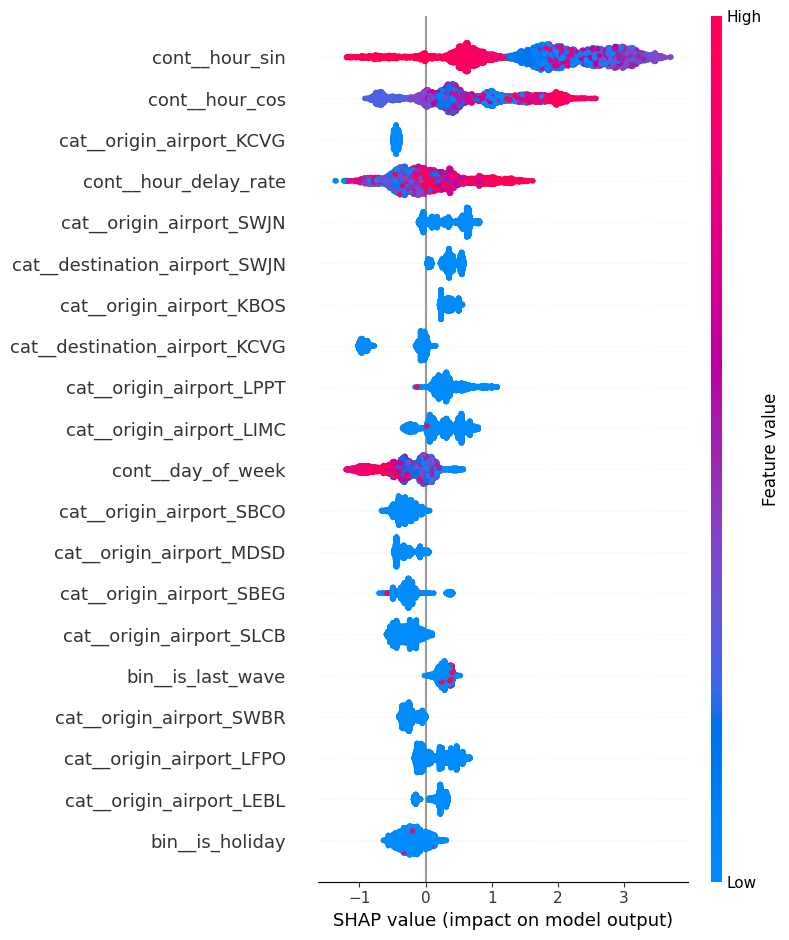

In [21]:
import shap
import numpy as np
import pandas as pd

# 🔹 Pegar nomes das features transformadas
preprocessor = pipeline_xgb.named_steps["preprocessor"]
feature_names = preprocessor.get_feature_names_out()

# 🔹 Amostragem
sample_size = 5000
idx = np.random.choice(X_test.shape[0], sample_size, replace=False)
X_sample_raw = X_test.iloc[idx]

# 🔹 Transformar
X_sample_transformed = preprocessor.transform(X_sample_raw)

# 🔹 Converter para dense se necessário
if hasattr(X_sample_transformed, "toarray"):
    X_sample_dense = X_sample_transformed.toarray()
else:
    X_sample_dense = X_sample_transformed

# 🔹 Criar DataFrame com nomes corretos
X_sample_df = pd.DataFrame(
    X_sample_dense,
    columns=feature_names
)

# 🔹 Criar explainer
explainer_xgb = shap.TreeExplainer(pipeline_xgb.named_steps["model"])

# 🔹 Calcular shap values
shap_values_xgb = explainer_xgb.shap_values(X_sample_df)

# 🔹 Summary plot
shap.summary_plot(shap_values_xgb, X_sample_df)

V5 – Case-Level Analysis (Extreme Probability Scenarios)

Beyond aggregate metrics, two real examples from the 2025 test set were selected to analyze individual model behavior.

Case Selection Strategy

High-confidence delay case:
The delayed flight with the highest predicted delay probability.

High-confidence non-delay case:
The on-time flight with the lowest predicted delay probability.

This allows inspection of:

How the model behaves in extreme confidence scenarios

Whether predictions align with realistic operational patterns

Potential overconfidence or miscalibration

Why This Matters

Aggregate metrics (AUC, Recall, F1) tell us how the model performs overall.

Case-level analysis tells us:

Does the model make reasonable decisions in real-world situations?

This step strengthens:

Interpretability

Model trustworthiness

Business validation

Technical Considerations

Original dtypes were preserved before passing cases back through the pipeline.

Probabilities were extracted using predict_proba.

The analysis ensures structural consistency with training data.

In [22]:
# 🔹 Adicionar probabilidade ao test_df
test_df_probs = X_test.copy()
test_df_probs["is_delayed"] = y_test
test_df_probs["prob_delay"] = pipeline_xgb.predict_proba(X_test)[:,1]

# 🔹 Caso atraso com maior probabilidade
case_delay = test_df_probs[
    test_df_probs["is_delayed"] == 1
].sort_values("prob_delay", ascending=False).iloc[0]

# 🔹 Caso não atraso com menor probabilidade
case_no_delay = test_df_probs[
    test_df_probs["is_delayed"] == 0
].sort_values("prob_delay", ascending=True).iloc[0]

# 🔹 Separar X
case_delay_X = case_delay.drop(["is_delayed", "prob_delay"]).to_frame().T
case_no_delay_X = case_no_delay.drop(["is_delayed", "prob_delay"]).to_frame().T

# 🔹 Ajustar dtype
case_delay_X = case_delay_X[X_test.columns].astype(X_test.dtypes.to_dict())
case_no_delay_X = case_no_delay_X[X_test.columns].astype(X_test.dtypes.to_dict())

print("Prob delay escolhida:", case_delay["prob_delay"])
print("Prob no delay escolhida:", case_no_delay["prob_delay"])

Prob delay escolhida: 0.97179157
Prob no delay escolhida: 0.025858428


In [23]:
case_delay_X

,airline,origin_airport,destination_airport,Partida Prevista,Partida Real,Situação Voo,delay_minutes,day_of_week,is_weekend,is_holiday,...,is_post_holiday,hour_sin,hour_cos,is_first_wave,is_last_wave,origin_volume,destination_volume,route_volume,airline_delay_rate,hour_delay_rate
2159013,AEA,LEMD,SBSV,2025-03-21 11:25:00,2025-03-21 12:02:00,REALIZADO,37.0,4,0,0,...,0,0.0,-1.0,0,0,3309.0,53651.0,245.0,0.684833,0.161352


In [24]:
case_no_delay_X

,airline,origin_airport,destination_airport,Partida Prevista,Partida Real,Situação Voo,delay_minutes,day_of_week,is_weekend,is_holiday,...,is_post_holiday,hour_sin,hour_cos,is_first_wave,is_last_wave,origin_volume,destination_volume,route_volume,airline_delay_rate,hour_delay_rate
2240847,AZU,SBSP,SBCF,2025-04-21 06:05:00,2025-04-21 05:53:00,REALIZADO,-12.0,0,0,1,...,0,0.965926,0.258819,1,0,184549.0,101784.0,16831.0,0.145374,0.062035


V5 – Local Explanation (SHAP Waterfall – Single Flight Analysis)

To deeply understand why the model predicted a specific flight as delayed, a SHAP waterfall plot was generated for the selected high-confidence delay case.

Objective

Break down the prediction into individual feature contributions and answer:

Which variables pushed this prediction toward delay?

Methodology

Extracted the transformed feature names from the preprocessing pipeline

Applied identical preprocessing to the selected case

Converted to dense format (required for SHAP visualization)

Generated SHAP values using TreeExplainer

Created a waterfall plot for a single prediction

What the Waterfall Plot Shows

Base value (average model output)

Positive contributions pushing toward delay (red)

Negative contributions pushing toward no delay (blue)

Final predicted probability

This provides a transparent breakdown of the model’s reasoning for one real flight.

Why This Is Powerful

Local interpretability enables:

Auditing individual predictions

Validating model logic against domain knowledge

Identifying possible bias or unrealistic feature influence

Supporting explainability in regulated environments

This transforms the model from a black-box predictor into an interpretable decision-support system.

Case delay

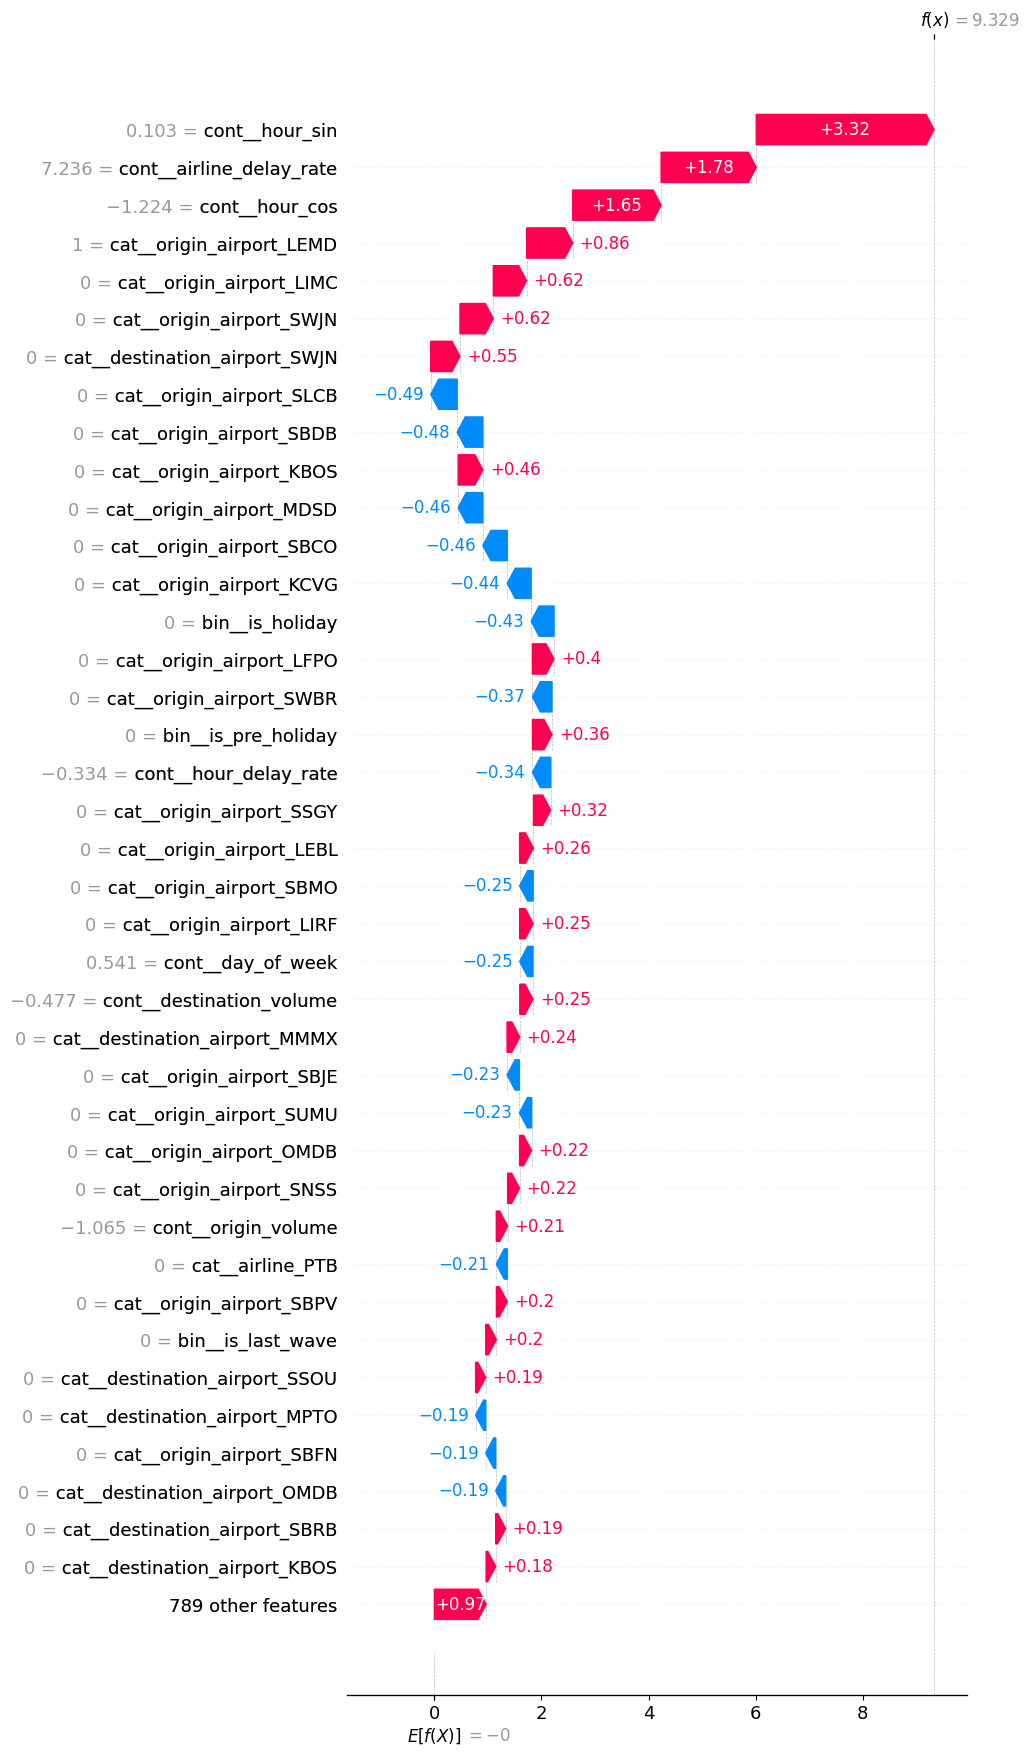

In [25]:
import shap
import numpy as np
import pandas as pd

# 🔹 Extrair nomes reais das features
feature_names = pipeline_xgb.named_steps['preprocessor'].get_feature_names_out()

# 🔹 Transformar caso individual
X_case_transformed = pipeline_xgb.named_steps['preprocessor'].transform(case_delay_X)

# 🔹 Converter para dense se necessário
if hasattr(X_case_transformed, "toarray"):
    X_case = X_case_transformed.toarray()
else:
    X_case = X_case_transformed

# 🔹 Criar DataFrame com nomes corretos
X_case_df = pd.DataFrame(
    X_case,
    columns=feature_names
)

# 🔹 Criar explainer (TreeExplainer)
explainer_xgb = shap.TreeExplainer(
    pipeline_xgb.named_steps['model']
)

# 🔹 Calcular shap values
shap_values_xgb = explainer_xgb(X_case_df)

# 🔹 Waterfall plot
shap.plots.waterfall(
    shap_values_xgb[0],
    max_display=40
)

V5 – Local Explanation (SHAP Waterfall – High-Confidence On-Time Flight)

To contrast the delayed case analysis, a SHAP waterfall plot was generated for a flight predicted with very high confidence as on-time.

Objective

Understand which features contributed to lowering the probability of delay and confirm whether the model's reasoning aligns with realistic operational patterns.

Methodology

Applied the exact same preprocessing pipeline used during training

Preserved feature ordering and data types

Generated SHAP values using TreeExplainer

Produced a waterfall plot for a single non-delayed prediction

Interpretation Focus

The waterfall plot highlights:

The model’s base value (average prediction baseline)

Features pushing the prediction toward delay (positive contribution)

Features pushing the prediction toward on-time status (negative contribution)

The final predicted probability

This enables direct comparison between:

A high-confidence delay case

A high-confidence non-delay case

Why This Completes the Analysis

By analyzing both extremes, we ensure:

Balanced interpretability

Confidence calibration

Operational plausibility

Transparent decision logic

This dual-case SHAP analysis provides a full-spectrum explanation of the model’s behavior.

Case no delay

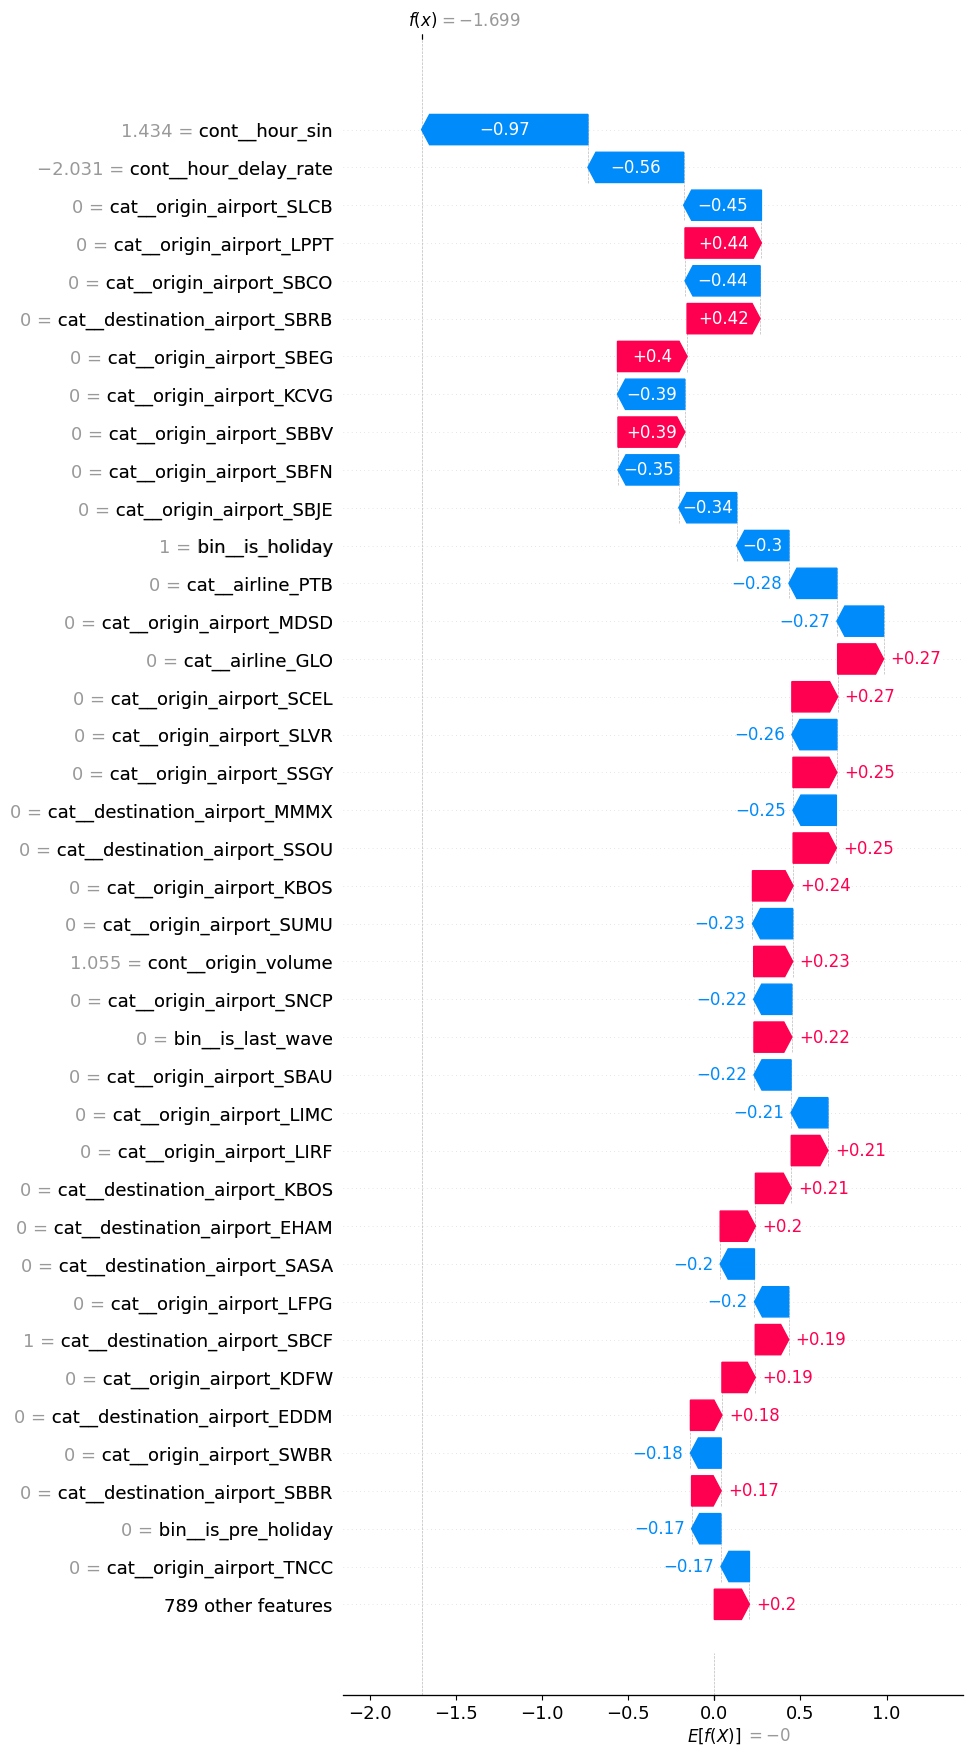

In [26]:
import shap
import numpy as np
import pandas as pd

# 🔹 Extrair nomes reais das features
feature_names = pipeline_xgb.named_steps['preprocessor'].get_feature_names_out()

# 🔹 Transformar caso individual
X_case_transformed = pipeline_xgb.named_steps['preprocessor'].transform(case_no_delay_X)

# 🔹 Converter para dense se necessário
if hasattr(X_case_transformed, "toarray"):
    X_case = X_case_transformed.toarray()
else:
    X_case = X_case_transformed

# 🔹 Criar DataFrame com nomes corretos
X_case_df = pd.DataFrame(
    X_case,
    columns=feature_names
)

# 🔹 Criar explainer (TreeExplainer)
explainer_xgb = shap.TreeExplainer(
    pipeline_xgb.named_steps['model']
)

# 🔹 Calcular shap values
shap_values_xgb = explainer_xgb(X_case_df)

# 🔹 Waterfall plot
shap.plots.waterfall(
    shap_values_xgb[0],
    max_display=40
)

V5 – Probability Calibration Analysis

Beyond classification performance, the model’s probability estimates were evaluated using a calibration curve.

What Is Calibration?

A well-calibrated model produces probabilities that reflect true event frequencies.

For example:

If the model predicts 0.70 probability of delay,

Then approximately 70% of those flights should actually be delayed.

Why This Matters

In operational systems, probabilities are often used for:

Risk ranking

Alert prioritization

Resource allocation

Decision thresholds

Poor calibration can lead to:

Overconfidence (too aggressive alerts)

Underconfidence (missed risk signals)

Interpreting the Curve

The dashed diagonal line represents perfect calibration.

The model curve shows how predicted probabilities compare to actual observed frequencies.

If the curve stays close to the diagonal, the model is well calibrated.
Deviations indicate overestimation or underestimation of delay risk.

Strategic Value

Calibration analysis strengthens:

Trust in probability outputs

Reliability of threshold tuning

Production-readiness of the model

This step ensures that the model is not only accurate in ranking delays, but also reliable in estimating risk levels.

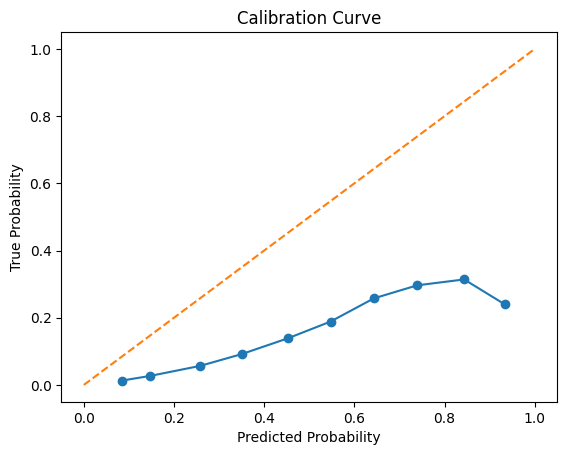

In [27]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

prob_true, prob_pred = calibration_curve(y_test, y_proba_xgb, n_bins=10)

plt.plot(prob_pred, prob_true, marker='o')
plt.plot([0,1],[0,1],'--')
plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve")
plt.show()

V5 – Probability Calibration Adjustment (Platt Scaling)

Although XGBoost provides probability estimates, tree-based models are not always perfectly calibrated.

To improve probability reliability, CalibratedClassifierCV was applied using sigmoid calibration (Platt Scaling).

Method

Base model: Full XGBoost pipeline

Calibration method: "sigmoid"

Cross-validation folds: cv=3

The calibration process learns a secondary mapping that adjusts predicted probabilities to better reflect true outcome frequencies.

Why Calibration Adjustment Matters

Well-calibrated probabilities are critical for:

Risk-based decision systems

Operational alert thresholds

Cost-sensitive optimization

Business confidence in probability outputs

Without calibration, a model may:

Overestimate delay risk

Underestimate true probabilities

Appear overconfident

What This Step Achieves

Improves probability reliability

Strengthens trust in threshold decisions

Enhances production-readiness

Aligns model outputs with real-world frequency interpretation

In [28]:
from sklearn.calibration import CalibratedClassifierCV

calibrated_xgb = CalibratedClassifierCV(
    pipeline_xgb,
    method="sigmoid",
    cv=3
)

calibrated_xgb.fit(X_train, y_train)

y_proba_calibrated = calibrated_xgb.predict_proba(X_test)[:,1]

In [29]:
import numpy as np
from sklearn.metrics import precision_recall_curve

precision, recall, thresholds = precision_recall_curve(
    y_test,
    y_proba_calibrated
)

step = max(1, len(thresholds)//10)

for i in range(0, len(thresholds), step):
    print(f"Threshold: {thresholds[i]:.3f} | Precision: {precision[i]:.3f} | Recall: {recall[i]:.3f}")

Threshold: 0.022 | Precision: 0.151 | Recall: 1.000
Threshold: 0.064 | Precision: 0.167 | Recall: 0.976
Threshold: 0.089 | Precision: 0.180 | Recall: 0.927
Threshold: 0.117 | Precision: 0.192 | Recall: 0.869
Threshold: 0.144 | Precision: 0.204 | Recall: 0.788
Threshold: 0.169 | Precision: 0.217 | Recall: 0.687
Threshold: 0.198 | Precision: 0.233 | Recall: 0.577
Threshold: 0.232 | Precision: 0.252 | Recall: 0.449
Threshold: 0.281 | Precision: 0.277 | Recall: 0.307
Threshold: 0.371 | Precision: 0.293 | Recall: 0.131
Threshold: 0.700 | Precision: 0.500 | Recall: 0.000


In [30]:
from sklearn.metrics import classification_report, roc_auc_score

# 🔹 Definir threshold (pode manter o mesmo ou recalibrar depois)
best_threshold = 0.169

# 🔹 Previsão binária usando probabilidade calibrada
y_pred_custom_cal = (y_proba_calibrated >= best_threshold).astype(int)

# 🔹 Relatório
print("=== Calibrated Model - Custom Threshold ===")
print(classification_report(y_test, y_pred_custom_cal))

# 🔹 AUC (usa probabilidade calibrada)
print("AUC (Calibrated):", roc_auc_score(y_test, y_proba_calibrated))

=== Calibrated Model - Custom Threshold ===
              precision    recall  f1-score   support

           0       0.91      0.56      0.69    805788
           1       0.22      0.69      0.33    143020

    accuracy                           0.58    948808
   macro avg       0.56      0.62      0.51    948808
weighted avg       0.81      0.58      0.64    948808

AUC (Calibrated): 0.6735861555082415


V5 – Post-Calibration Evaluation

After applying probability calibration (Platt Scaling), the calibration curve was recomputed to verify whether probability estimates improved.

Objective

Compare calibrated probabilities against the ideal reference line (perfect calibration).

If calibration was effective:

The curve should move closer to the diagonal.

Probability estimates should better reflect real delay frequencies.

Overconfidence or underconfidence should decrease.

Interpretation Guide

Closer to diagonal → Better probability reliability

Above diagonal → Model underestimates delay probability

Below diagonal → Model overestimates delay probability

This final validation step confirms whether calibration enhanced the model’s probabilistic trustworthiness.

Why This Completes the Evaluation

The project now includes:

Performance metrics (AUC, Precision, Recall, F1)

Threshold optimization

Global interpretability (Feature Importance & SHAP Summary)

Local interpretability (SHAP Waterfall)

Probability calibration analysis

Calibration correction validation

This ensures the model is not only predictive, but also reliable, interpretable, and production-aligned.

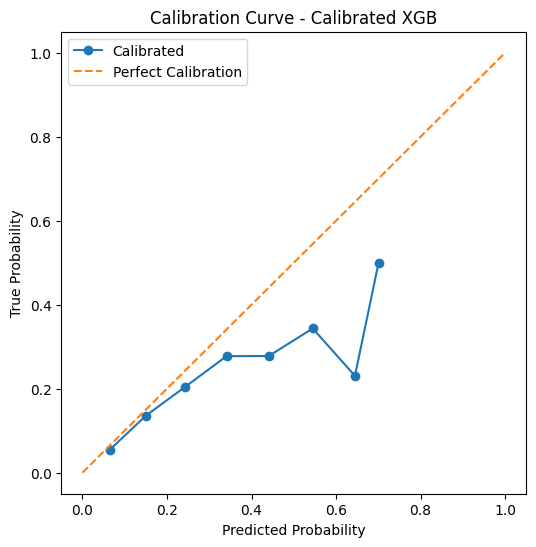

In [31]:
from sklearn.calibration import calibration_curve
import matplotlib.pyplot as plt

# Curva calibrada
prob_true_cal, prob_pred_cal = calibration_curve(
    y_test,
    y_proba_calibrated,
    n_bins=10
)

plt.figure(figsize=(6,6))
plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='Calibrated')
plt.plot([0,1],[0,1],'--', label='Perfect Calibration')

plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve - Calibrated XGB")
plt.legend()
plt.show()

V5 – Calibration Curve Comparison (Original vs Calibrated)

To objectively assess the impact of probability calibration, the calibration curves of both models were plotted side by side:

Original XGBoost probabilities

Calibrated XGBoost probabilities (Platt Scaling)

Both were compared against the ideal diagonal line representing perfect calibration.

Objective

Evaluate whether calibration improved the alignment between:

Predicted probabilities

True observed delay frequencies

If calibration is effective, the calibrated curve should move closer to the diagonal reference line.

Interpretation Framework

Curve below diagonal → Model is overconfident

Curve above diagonal → Model is underconfident

Curve near diagonal → Well-calibrated probabilities

The comparison visually demonstrates whether probability estimates became more reliable after calibration.

Why This Is a Strong Validation Step

This analysis confirms:

Whether calibration was necessary

Whether it improved probability reliability

Whether threshold tuning can now be trusted

Whether the model is suitable for risk-based decision systems

This moves the project beyond accuracy and into probabilistic reliability assessment, which is critical in real-world ML systems.

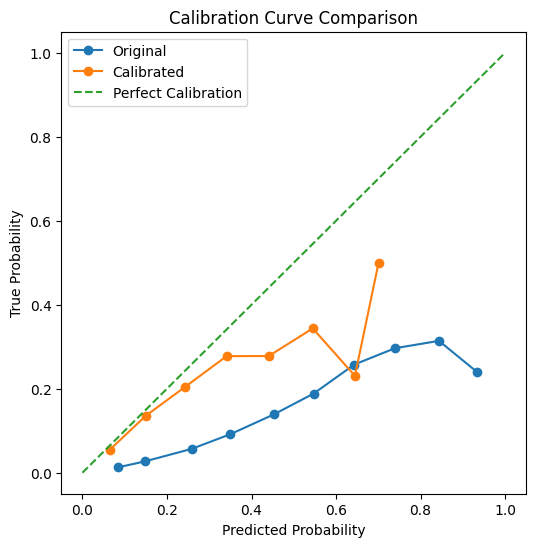

In [32]:
prob_true_raw, prob_pred_raw = calibration_curve(
    y_test,
    y_proba_xgb,   # modelo original
    n_bins=10
)

prob_true_cal, prob_pred_cal = calibration_curve(
    y_test,
    y_proba_calibrated,
    n_bins=10
)

plt.figure(figsize=(6,6))

plt.plot(prob_pred_raw, prob_true_raw, marker='o', label='Original')
plt.plot(prob_pred_cal, prob_true_cal, marker='o', label='Calibrated')
plt.plot([0,1],[0,1],'--', label='Perfect Calibration')

plt.xlabel("Predicted Probability")
plt.ylabel("True Probability")
plt.title("Calibration Curve Comparison")
plt.legend()
plt.show()

V5 – Case-Level Analysis After Probability Calibration

After calibrating the model’s probability estimates, the extreme cases were recomputed using calibrated probabilities.

Why Recompute Cases?

Calibration adjusts the probability scale to better reflect real-world frequencies.

This means:

A predicted probability of 0.80 should now correspond more closely to ~80% real delay frequency.

Extreme confidence cases become more trustworthy.

Risk interpretation becomes more realistic.

Objective

Select:

The delayed flight with the highest calibrated delay probability

The on-time flight with the lowest calibrated delay probability

These cases represent the most confident predictions after probability correction.

Why This Step Is Important

Using calibrated probabilities ensures that:

Confidence levels are not artificially inflated

Risk ranking is more reliable

Decision thresholds align with real operational frequency

This strengthens trust in case-level explanations and SHAP analysis.

In [33]:
# 🔹 Adicionar probabilidade ao test_df
test_df_probs = X_test.copy()
test_df_probs["is_delayed"] = y_test
test_df_probs["prob_delay"] = calibrated_xgb.predict_proba(X_test)[:,1]

# 🔹 Caso atraso com maior probabilidade
case_delay = test_df_probs[
    test_df_probs["is_delayed"] == 1
].sort_values("prob_delay", ascending=False).iloc[0]

# 🔹 Caso não atraso com menor probabilidade
case_no_delay = test_df_probs[
    test_df_probs["is_delayed"] == 0
].sort_values("prob_delay", ascending=True).iloc[0]

# 🔹 Separar X
case_delay_X = case_delay.drop(["is_delayed", "prob_delay"]).to_frame().T
case_no_delay_X = case_no_delay.drop(["is_delayed", "prob_delay"]).to_frame().T

# 🔹 Ajustar dtype
case_delay_X = case_delay_X[X_test.columns].astype(X_test.dtypes.to_dict())
case_no_delay_X = case_no_delay_X[X_test.columns].astype(X_test.dtypes.to_dict())

print("Prob delay escolhida:", case_delay["prob_delay"])
print("Prob no delay escolhida:", case_no_delay["prob_delay"])

Prob delay escolhida: 0.7009951986949726
Prob no delay escolhida: 0.022491696887304336


Case delay

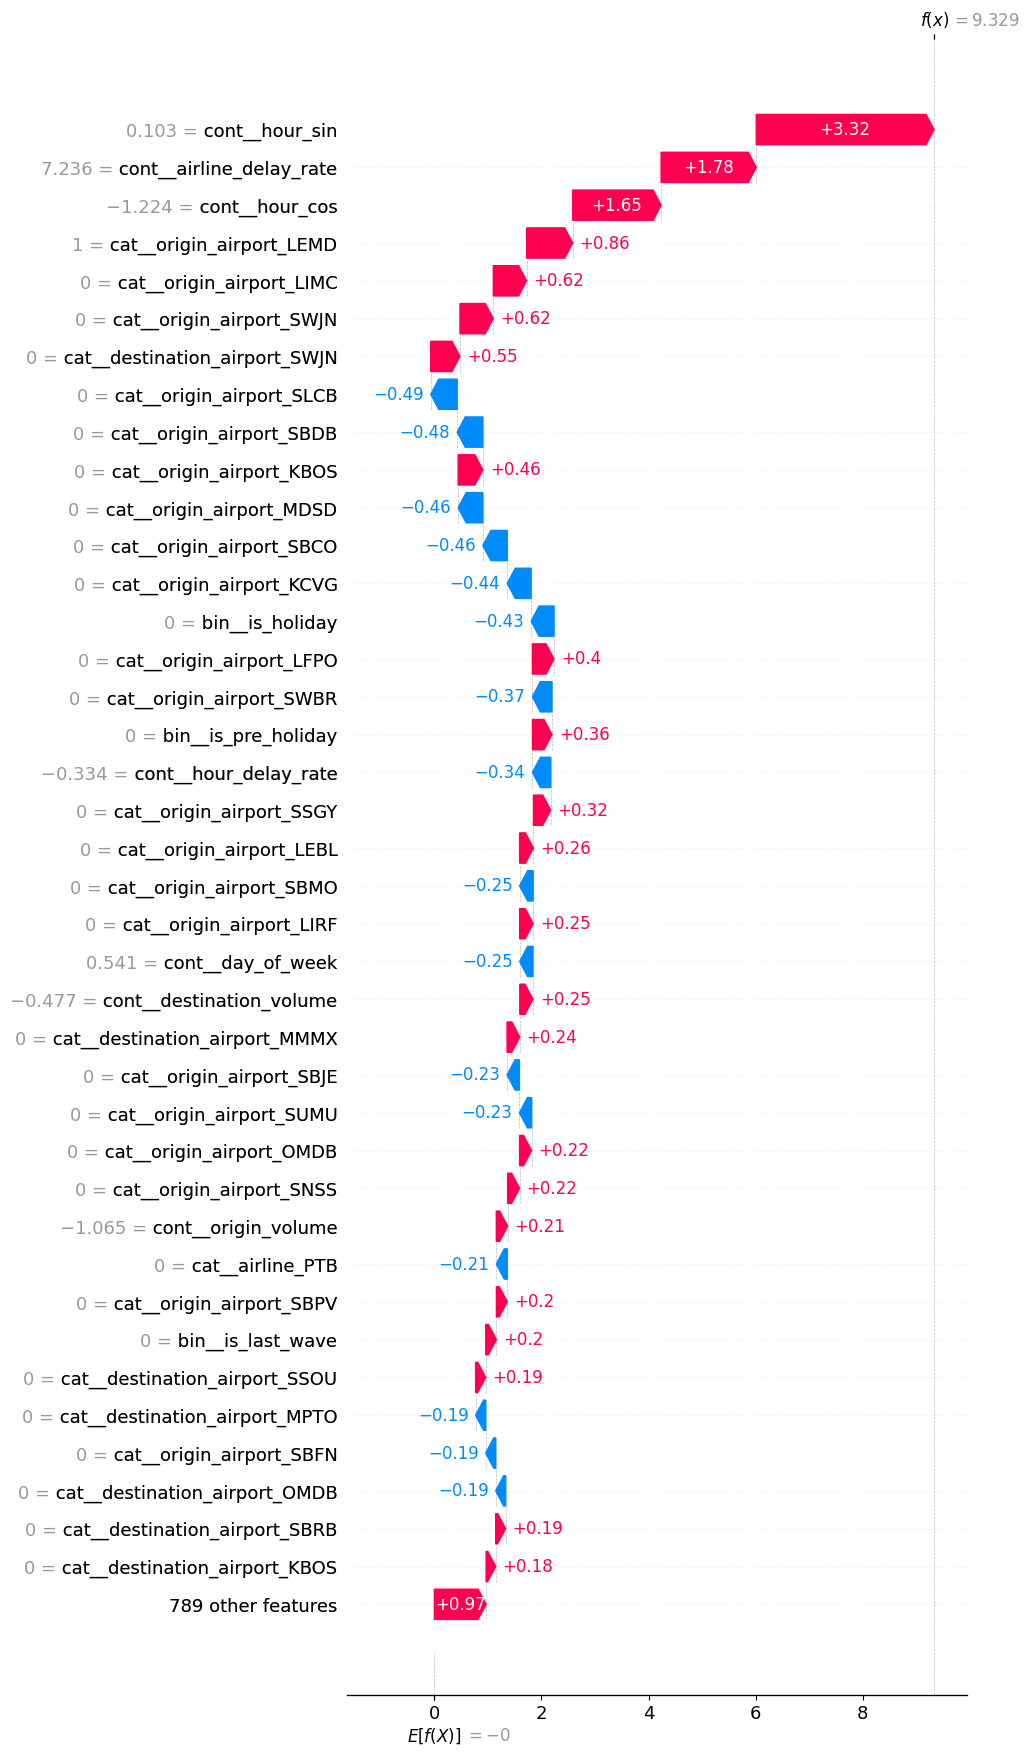

In [34]:
import shap
import numpy as np
import pandas as pd

# ==============================
# 1️⃣ Extrair preprocessor do pipeline ORIGINAL
# ==============================

preprocessor = pipeline_xgb.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# ==============================
# 2️⃣ Transformar caso individual
# ==============================

X_case_transformed = preprocessor.transform(case_delay_X)

if hasattr(X_case_transformed, "toarray"):
    X_case = X_case_transformed.toarray()
else:
    X_case = X_case_transformed

X_case_df = pd.DataFrame(
    X_case,
    columns=feature_names
)

# ==============================
# 3️⃣ Modelo XGB original
# ==============================

xgb_model = pipeline_xgb.named_steps['model']

explainer_xgb = shap.TreeExplainer(xgb_model)

# ==============================
# 4️⃣ Calcular SHAP values
# ==============================

shap_values_xgb = explainer_xgb(X_case_df)

# ==============================
# 5️⃣ Waterfall Plot
# ==============================

shap.plots.waterfall(
    shap_values_xgb[0],
    max_display=40
)

Case no delay

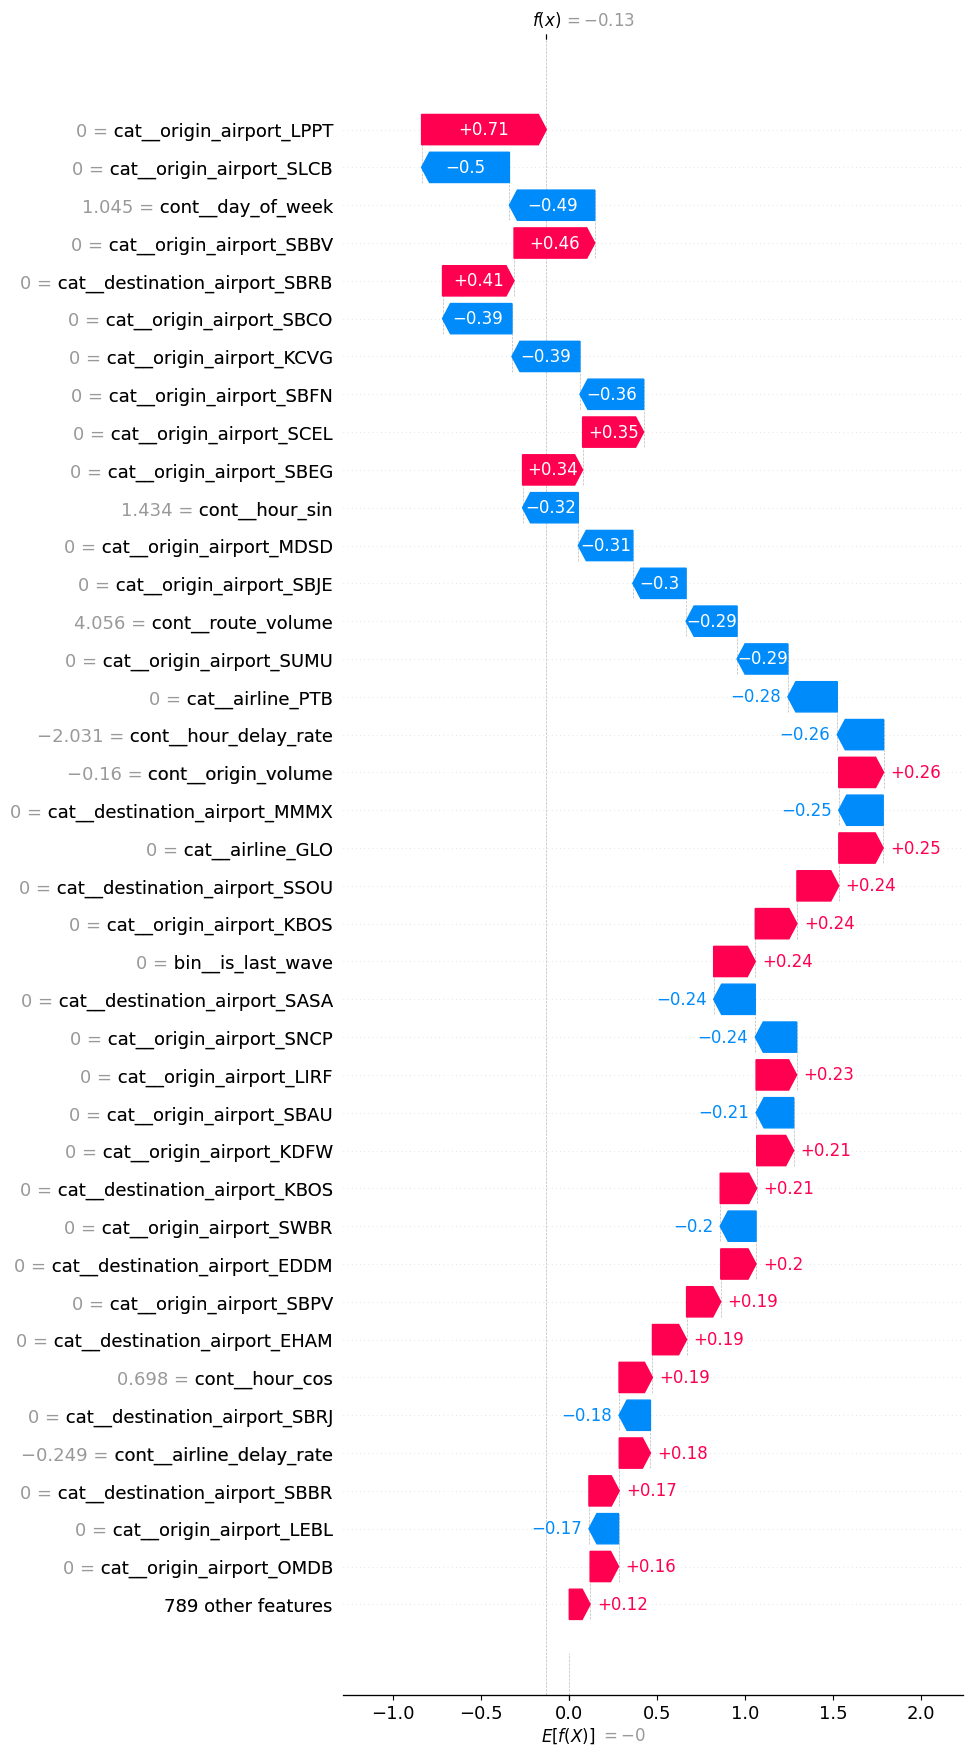

In [35]:
import shap
import numpy as np
import pandas as pd

# ==============================
# 1️⃣ Extrair preprocessor do pipeline original
# ==============================

preprocessor = pipeline_xgb.named_steps['preprocessor']
feature_names = preprocessor.get_feature_names_out()

# ==============================
# 2️⃣ Transformar caso individual (no delay)
# ==============================

X_case_transformed = preprocessor.transform(case_no_delay_X)

if hasattr(X_case_transformed, "toarray"):
    X_case = X_case_transformed.toarray()
else:
    X_case = X_case_transformed

X_case_df = pd.DataFrame(
    X_case,
    columns=feature_names
)

# ==============================
# 3️⃣ Extrair modelo XGB estrutural
# ==============================

xgb_model = pipeline_xgb.named_steps['model']

explainer_xgb = shap.TreeExplainer(xgb_model)

# ==============================
# 4️⃣ Calcular SHAP values
# ==============================

shap_values_xgb = explainer_xgb(X_case_df)

# ==============================
# 5️⃣ Waterfall Plot
# ==============================

shap.plots.waterfall(
    shap_values_xgb[0],
    max_display=40
)

joblib

In [37]:
import joblib

joblib.dump(pipeline_xgb, "xgb_pipeline.pkl")

['xgb_pipeline.pkl']

In [54]:
%%writefile model_wrapper.py

import joblib
import shap
import numpy as np
import pandas as pd
import holidays


class FlightDelayPredictor:

    def __init__(self, model_path: str,
                 stats_path: str = "historical_stats_v5.pkl",
                 threshold: float = 0.5):

        # Load pipeline
        self.pipeline = joblib.load(model_path)
        self.threshold = threshold

        self.preprocessor = self.pipeline.named_steps["preprocessor"]
        self.model = self.pipeline.named_steps["model"]

        # Load historical stats
        self.historical_stats = joblib.load(stats_path)

        self.origin_volume_map = self.historical_stats["origin_volume"]
        self.destination_volume_map = self.historical_stats["destination_volume"]
        self.route_volume_map = self.historical_stats["route_volume"]
        self.airline_delay_rate_map = self.historical_stats["airline_delay_rate"]
        self.hour_delay_rate_map = self.historical_stats["hour_delay_rate"]
        self.global_delay_rate = self.historical_stats["global_delay_rate"]

        # SHAP
        self.explainer = shap.TreeExplainer(self.model)
        self.feature_names = self.preprocessor.get_feature_names_out()

    # ====================================================
    # Hour encoding
    # ====================================================
    def _encode_hour(self, hour: int):
        hour_sin = np.sin(2 * np.pi * hour / 24)
        hour_cos = np.cos(2 * np.pi * hour / 24)
        return hour_sin, hour_cos

    # ====================================================
    # Date features (replicates ETL)
    # ====================================================
    def _apply_date_features(self, df: pd.DataFrame):

        df["departure_datetime"] = pd.to_datetime(
            df["departure_datetime"],
            errors="coerce"
        )

        if df["departure_datetime"].isna().any():
            raise ValueError("Invalid departure_datetime format.")

        df["hour"] = df["departure_datetime"].dt.hour
        df["day_of_week"] = df["departure_datetime"].dt.dayofweek.astype("Int8")
        df["is_weekend"] = (df["day_of_week"] >= 5).astype("Int8")

        dates = df["departure_datetime"].dt.normalize()
        years = dates.dt.year.unique()

        br_holidays = holidays.Brazil(years=years)
        holiday_dates = pd.DatetimeIndex(br_holidays.keys()).normalize()

        df["is_holiday"] = dates.isin(holiday_dates).astype("Int8")
        df["is_pre_holiday"] = (
            (dates + pd.Timedelta(days=1)).isin(holiday_dates)
        ).astype("Int8")

        df["is_post_holiday"] = (
            (dates - pd.Timedelta(days=1)).isin(holiday_dates)
        ).astype("Int8")

        df["is_first_wave"] = (df["hour"] <= 7).astype("Int8")
        df["is_last_wave"] = (df["hour"] >= 20).astype("Int8")

        hour_sin, hour_cos = self._encode_hour(df["hour"].iloc[0])
        df["hour_sin"] = hour_sin
        df["hour_cos"] = hour_cos

        return df

    # ====================================================
    # Historical aggregations
    # ====================================================
    def _apply_aggregations(self, df: pd.DataFrame):

        df["route"] = df["origin_airport"] + "_" + df["destination_airport"]

        df["origin_volume"] = df["origin_airport"].map(self.origin_volume_map)
        df["destination_volume"] = df["destination_airport"].map(self.destination_volume_map)
        df["route_volume"] = df["route"].map(self.route_volume_map)

        df["airline_delay_rate"] = df["airline"].map(self.airline_delay_rate_map)
        df["hour_delay_rate"] = df["hour"].map(self.hour_delay_rate_map)

        df["airline_delay_rate"] = df["airline_delay_rate"].fillna(self.global_delay_rate)
        df["hour_delay_rate"] = df["hour_delay_rate"].fillna(self.global_delay_rate)

        df = df.drop(columns=["route", "departure_datetime"])

        return df

    # ====================================================
    # Prepare input
    # ====================================================
    def _prepare_input(self, input_data: dict):

        required_fields = [
            "airline",
            "origin_airport",
            "destination_airport",
            "departure_datetime"
        ]

        for field in required_fields:
            if field not in input_data:
                raise ValueError(f"Missing required field: {field}")

        X = pd.DataFrame([input_data])

        X = self._apply_date_features(X)
        X = self._apply_aggregations(X)

        return X

    # ====================================================
    # Predict
    # ====================================================
    def predict(self, input_data: dict):

        X = self._prepare_input(input_data)

        probs = self.pipeline.predict_proba(X)[0]

        prob_no_delay = float(probs[0])
        prob_delay = float(probs[1])

        predicted_class = int(prob_delay >= self.threshold)
        label = "Delayed" if predicted_class == 1 else "On Time"

        return {
            "prediction": predicted_class,
            "label": label,
            "probability_delay": prob_delay,
            "probability_no_delay": prob_no_delay,
            "threshold_used": self.threshold
        }

    # ====================================================
    # SHAP explanation (API-ready)
    # ====================================================
    def explain(self, input_data: dict, top_n: int = 10):

        X = self._prepare_input(input_data)
        X_original = X.iloc[0]

        X_transformed = self.preprocessor.transform(X)

        if hasattr(X_transformed, "toarray"):
            X_transformed = X_transformed.toarray()

        shap_values = self.explainer(X_transformed)
        values = shap_values.values[0]

        idx_sorted = np.argsort(np.abs(values))[::-1]

        top_features = []

        for i in idx_sorted:

            feature_name = self.feature_names[i]
            transformed_value = X_transformed[0][i]

            # Ignore inactive OneHot
            if "cat__" in feature_name and abs(transformed_value) < 1e-9:
                continue

            if "hour_sin" in feature_name or "hour_cos" in feature_name:
                continue

            clean_name = (
                feature_name
                .replace("cont__", "")
                .replace("bin__", "")
                .replace("cat__", "")
            )

            impact = float(values[i])

            # Extract correct value
            if clean_name.startswith("airline_") and clean_name != "airline_delay_rate":
                original_value = input_data["airline"]

            elif clean_name.startswith("origin_airport_"):
                original_value = input_data["origin_airport"]

            elif clean_name.startswith("destination_airport_"):
                original_value = input_data["destination_airport"]

            else:
                original_value = X_original.get(clean_name, None)

            # Convert numpy types
            if isinstance(original_value, (np.integer,)):
                original_value = int(original_value)

            if isinstance(original_value, (np.floating,)):
                original_value = float(original_value)

            top_features.append({
                "feature": clean_name,
                "value": original_value,
                "impact": impact,
                "direction": "increase_delay" if impact > 0 else "decrease_delay"
            })

            if len(top_features) >= top_n:
                break

        return top_features

    # ====================================================
    # Full response
    # ====================================================
    def predict_with_explanation(self, input_data: dict, top_n: int = 10):

        prediction_output = self.predict(input_data)
        shap_output = self.explain(input_data, top_n=top_n)

        return {
            **prediction_output,
            "departure_datetime": input_data["departure_datetime"],
            "top_factors": shap_output
        }

Overwriting model_wrapper.py


In [55]:
import importlib
import model_wrapper

importlib.reload(model_wrapper)

from model_wrapper import FlightDelayPredictor

In [56]:
from model_wrapper import FlightDelayPredictor

predictor = FlightDelayPredictor(
    model_path="xgb_pipeline.pkl",
    stats_path="historical_stats_v5.pkl",
    threshold=0.169  # ou o que você escolheu
)

input_data = {
    "airline": "GLO",
    "origin_airport": "SBGR",
    "destination_airport": "SBRJ",
    "departure_datetime": "2025-03-15 14:30:00"
}

result = predictor.predict_with_explanation(input_data)

print(result)

{'prediction': 1, 'label': 'Delayed', 'probability_delay': 0.5334041714668274, 'probability_no_delay': 0.4665958285331726, 'threshold_used': 0.169, 'departure_datetime': '2025-03-15 14:30:00', 'top_factors': [{'feature': 'day_of_week', 'value': 5, 'impact': -0.8911404013633728, 'direction': 'decrease_delay'}, {'feature': 'hour_delay_rate', 'value': 0.17985675039246468, 'impact': 0.4590020179748535, 'direction': 'increase_delay'}, {'feature': 'is_last_wave', 'value': 0, 'impact': 0.23452584445476532, 'direction': 'increase_delay'}, {'feature': 'origin_volume', 'value': 258226, 'impact': 0.186769500374794, 'direction': 'increase_delay'}, {'feature': 'is_pre_holiday', 'value': 0, 'impact': 0.18177489936351776, 'direction': 'increase_delay'}, {'feature': 'is_holiday', 'value': 0, 'impact': -0.17722056806087494, 'direction': 'decrease_delay'}, {'feature': 'airline_GLO', 'value': 'GLO', 'impact': 0.16365782916545868, 'direction': 'increase_delay'}, {'feature': 'airline_delay_rate', 'value': 